# 1. Librerias y Constantes (Setup Enviorment)

In [1]:
import os
import pandas as pd
import numpy as np
import json

import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix

from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv

import networkx as nx
from networkx.readwrite import json_graph

import seaborn as sns
import matplotlib.pyplot as plt

from Utils.Grafos_Utils import plot_graph, Dataset, informacion_de_vertices, distribucion_probabilidades

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
PATH = os.path.join('Data', 'PPI')

# 2. Contexto (Context)

<a href="https://arxiv.org/abs/1707.04638">Predicting multicellular function through multi-layer tissue networks </a>

Generalmente a la hora de clasificar proteinas se ignora las relaciones entre los tejidos como si las funciones corporales de las proteinas en el corazón fueran iguales a las del cerebro, por ejemplo. 

La idea es modelar la organización de los tejidos a travé de sus proteinas, sin ignorar las realciones entre estos. Para esto se tiene un dataset que contiene la función multicelular en una red de interacción de proteínas multicapa de 107 tejidos humanos. En 48 tejidos con funciones celulares específicas de tejido conocidas.

# <a href="http://snap.stanford.edu/ohmnet/"> Dataset </a>

El dataset está dividio en 3 grupos:

Train:
20 grafos

Test:
2 Grafos

Val:
2 Grafos

Cáda grafo contienen un conjunto de proteinas (nodos) y sus relaciones. Cada nodo representa una proteína por 50 características y está etiquetado con 121 etiquetas no exclusivas. Cada una de las clases se asignaron con base en ontologías que se pueden consultar en: http://geneontology.org/docs/ontology-documentation/

In [4]:
train_dataset = PPI(PATH, split='train')
val_dataset = PPI(PATH, split='val')
test_dataset = PPI(PATH, split='test')

In [5]:
# Información básica sobre el dataset:
print(f'Número de grafos (graphs): {len(train_dataset)}')
print(f'Número de características (features): {train_dataset.num_features}')
print(f'Número de clases (classes): {train_dataset.num_classes}')
print(50*'=')

# Tomar un grafo como ejémplo para ver su información:
data_eg = train_dataset[0]  

# alguna información del grafo:
print(data_eg)
print(f'Número de nodos (nodes): {data_eg.num_nodes}')
print(f'Número de características por nodo (Features per node): {data_eg.x.shape}')
print(f'Número de vertices (edges): {data_eg.num_edges}')
print(f'Etiquetas de cada nodo (Labels): {data_eg.y.shape}')
print(f'Es no dirigido (undirected): {data_eg.is_undirected()}')

Número de grafos (graphs): 20
Número de características (features): 50
Número de clases (classes): 121
Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Número de nodos (nodes): 1767
Número de características por nodo (Features per node): torch.Size([1767, 50])
Número de vertices (edges): 32318
Etiquetas de cada nodo (Labels): torch.Size([1767, 121])
Es no dirigido (undirected): True


# 3. Análisis del Gráfo (Graph analysis):

Como podemos ver el conjunto de datos se muy grande, por lo cual el análisis se hará sobre un subset de datos

As the number pf graphs and nodes is so large, we will use a subgraph

In [6]:
data = Dataset('train', PATH)

In [7]:
subgrafo = data.subgrafo(400)
# Ver información de los vertices (Edges information):
bidirectional, auto = informacion_de_vertices(subgrafo.edges)

# Hacemos el grafo sin direcciónes (Graph to undirected)
subgrafo = nx.Graph(subgrafo)
#subgrafo.remove_edges_from(auto)
subgrafo = subgrafo.to_undirected()

El número de vertices (edges): 2780
El número de vertices bidireccionales (bidirectional edges) 2380
El número de relaciones de nodos con ellos mismos es (self-loops) 400
 De los 2780 vertices, 2780 son realciones bidireccionales o con ellos mismos


### 3.1 Información del Grafo (Graph Information)

In [8]:
informacion_de_vertices(subgrafo.edges)
print(f'El número de nodos (Nodes) es : {len(subgrafo.nodes)}')

El número de vertices (edges): 1590
El número de vertices bidireccionales (bidirectional edges) 0
El número de relaciones de nodos con ellos mismos es (self-loops) 400
 De los 1590 vertices, 400 son realciones bidireccionales o con ellos mismos
El número de nodos (Nodes) es : 400


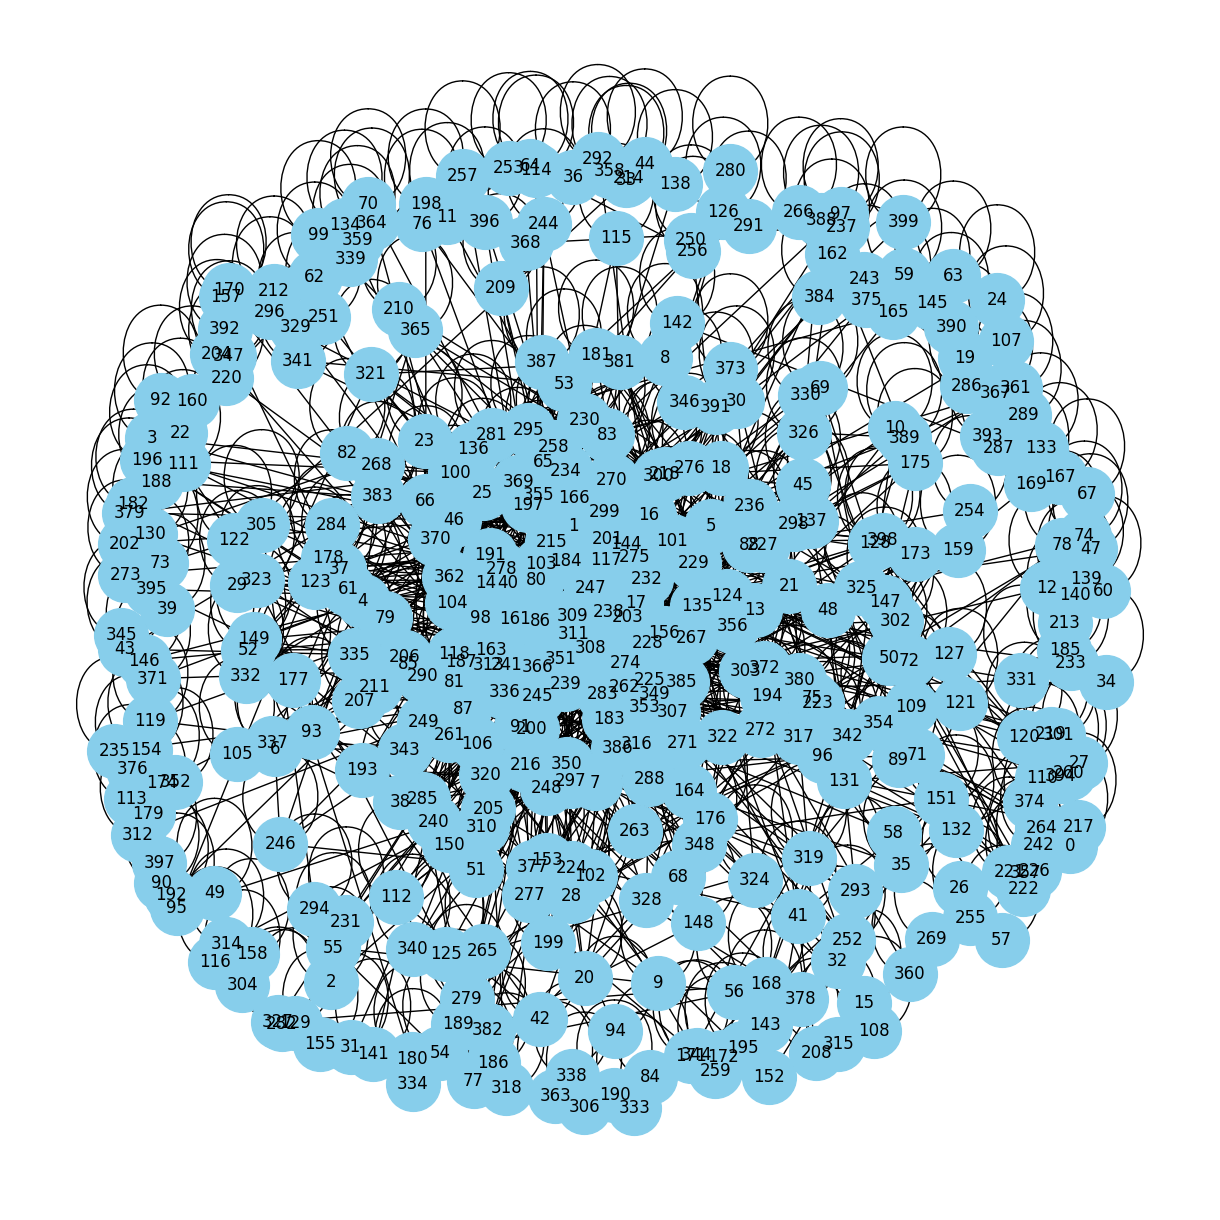

In [9]:
plot_graph(subgrafo)

### 3.2. Matriz de Adyacencia (Adjacency Matrix)

In [10]:
A = nx.adjacency_matrix(subgrafo)
#A.setdiag(1)
print(A.todense())

[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


In [11]:
if np.all(A.T.todense() == A.todense()):
    print('La matriz de adyacencia y su transpuesta son iguales, por lo tanto es no dirigido (Is undirected)')

La matriz de adyacencia y su transpuesta son iguales, por lo tanto es no dirigido (Is undirected)


### 3.3. Vecindad (neighborhood)

In [12]:
# Método 1 (Method 1)
# Podemos calcularla sumando las filas (columnas, porque es simétrica al ser no dirigido) de la matriz de adyacencia
np.sum(A, axis=0)

matrix([[ 2,  9,  3,  3, 14,  6,  6, 12,  5,  3,  4,  2,  1,  8,  7,  3,
         20, 25, 10,  1,  6,  6,  1, 13,  1,  8,  1,  5,  6,  5,  5,  2,
          4,  1,  1,  6,  1, 12,  6,  1, 17,  6,  4,  3,  1,  6, 27,  2,
          7,  1,  6,  5,  5,  7,  3,  4,  3,  1,  3,  2,  1,  9,  2,  1,
          2,  7, 14,  1,  5,  6,  3,  4,  4,  1,  3,  6,  3,  5,  3, 10,
         43, 14,  7,  9,  1, 15, 37, 14, 17,  4,  1,  6,  1,  6,  2,  3,
          6,  3, 21,  2, 24, 26,  5, 22, 18,  5, 10,  2,  1,  9,  1,  4,
          5,  1,  4,  3,  1, 12,  6,  3,  7,  7,  4,  8,  7,  3,  3,  8,
          8,  1,  2,  5,  3,  1,  2, 30, 11,  6,  2,  2,  1,  2,  4,  1,
         18,  1,  3,  7,  5,  5,  7,  4,  4,  5,  1,  1, 20,  4,  1,  4,
          1, 17,  5,  9, 13,  3,  8,  1,  4,  2,  1,  2,  2,  4,  2,  7,
          8,  3,  7,  1,  2,  6,  2, 20, 13,  1,  1, 14,  2,  3,  1, 29,
          2,  5, 14,  1,  5, 15,  3,  4, 13, 13,  3, 11,  2,  4,  6,  5,
          3,  3,  3, 11,  1,  1,  2, 12, 21,  3,  8

In [13]:
# Método 2 (Method 2)
# También podemos usar la función degree de networkx:
# La diferencia entre los dos métodos es que el primer método (Sumando de la matriz) cuenta también los self-loops
grados = subgrafo.degree()
grados

DegreeView({0: 3, 1: 10, 2: 4, 3: 4, 4: 15, 5: 7, 6: 7, 7: 13, 8: 6, 9: 4, 10: 5, 11: 3, 12: 2, 13: 9, 14: 8, 15: 4, 16: 21, 17: 26, 18: 11, 19: 2, 20: 7, 21: 7, 22: 2, 23: 14, 24: 2, 25: 9, 26: 2, 27: 6, 28: 7, 29: 6, 30: 6, 31: 3, 32: 5, 33: 2, 34: 2, 35: 7, 36: 2, 37: 13, 38: 7, 39: 2, 40: 18, 41: 7, 42: 5, 43: 4, 44: 2, 45: 7, 46: 28, 47: 3, 48: 8, 49: 2, 50: 7, 51: 6, 52: 6, 53: 8, 54: 4, 55: 5, 56: 4, 57: 2, 58: 4, 59: 3, 60: 2, 61: 10, 62: 3, 63: 2, 64: 3, 65: 8, 66: 15, 67: 2, 68: 6, 69: 7, 70: 4, 71: 5, 72: 5, 73: 2, 74: 4, 75: 7, 76: 4, 77: 6, 78: 4, 79: 11, 80: 44, 81: 15, 82: 8, 83: 10, 84: 2, 85: 16, 86: 38, 87: 15, 88: 18, 89: 5, 90: 2, 91: 7, 92: 2, 93: 7, 94: 3, 95: 4, 96: 7, 97: 4, 98: 22, 99: 3, 100: 25, 101: 27, 102: 6, 103: 23, 104: 19, 105: 6, 106: 11, 107: 3, 108: 2, 109: 10, 110: 2, 111: 5, 112: 6, 113: 2, 114: 5, 115: 4, 116: 2, 117: 13, 118: 7, 119: 4, 120: 8, 121: 8, 122: 5, 123: 9, 124: 8, 125: 4, 126: 4, 127: 9, 128: 9, 129: 2, 130: 3, 131: 6, 132: 4, 133: 2

In [14]:
grados = np.array(grados)

# Nodo con el máximo grado (Max degree node):
# Indide del máximo valor
index = np.argmax(grados[:,1])
max_d = grados[index, 1]
print(f'El grado máximo es el nodo (node): {grados[index, 0]} con un in-degree/ out-degree: {max_d}')

# Nodo con el mínimo grado (Min degree node):
# Indide del mínimo valor
index = np.argmin(grados[:,1])
print(f'El grado mínimo es el nodo (node): {grados[index, 0]} con un in-degree/ out-degree: {grados[index, 1]}')

# Grado promedio (Mean degree):
mean = grados[:,1].mean()
print(f'El Grado promedio (Mean degree): {mean}')
std = grados[:,1].std()
print(f'Standard deviation: {std}')

El grado máximo es el nodo (node): 349 con un in-degree/ out-degree: 50
El grado mínimo es el nodo (node): 12 con un in-degree/ out-degree: 2
El Grado promedio (Mean degree): 7.95
Standard deviation: 7.344215410784191


### 3.4. Distribución de grado en el grafo (Degree distribution of the graph)

#### 1. Probability Density Function (PDF)
#### 2. Complementary Cumulative Distribution Function (CCDF)

In [15]:
# Nos quedamos solo con los grados (Take just the degrees)
valores_grado = grados[:,1]
valores_grado.sort()
valores_grado

array([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6

In [57]:
pdf, ecdf, grado_indice = distribucion_probabilidades(valores_grado)

### 3.4.1. PDF

In [58]:
def plot_pdf(pdf, grado_indice, x=None, y=None):
    grid = sns.lineplot(x=grado_indice, y=pdf)
    grid.set(xlim=0)

    if x=='log' and y=='log':
        grid.set(xscale="log", yscale="log")
        plt.xlabel('Grado [log]')
        plt.ylabel('Probabilidad [log]')
        plt.title('PDF log - log')

    elif x=='log':
        grid.set(xscale="log")
        plt.xlabel('Grado [log]')
        plt.ylabel('Probabilidad')
        plt.title('PDF linear - log')
    elif y=='log':
        grid.set(yscale="log")
        plt.xlabel('Grado')
        plt.ylabel('Probabilidad [log]')
        plt.title('PDF log - linear')
    else:
        plt.xlabel('Grado')
        plt.ylabel('Probabilidad')
        plt.title('PDF')
    grid.set(xlim=0)
    plt.show()

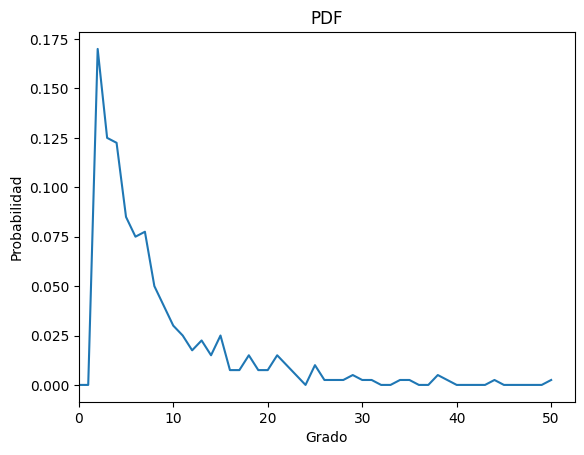

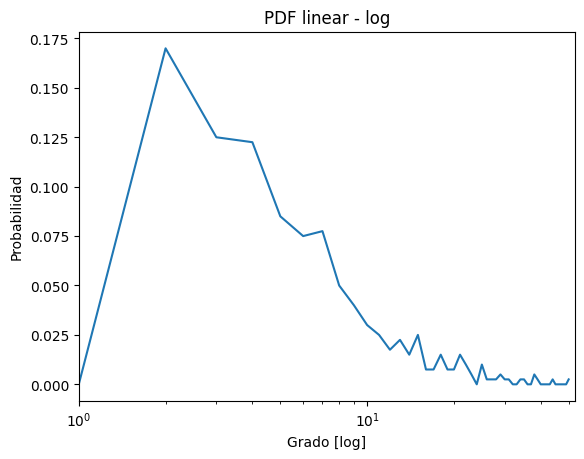

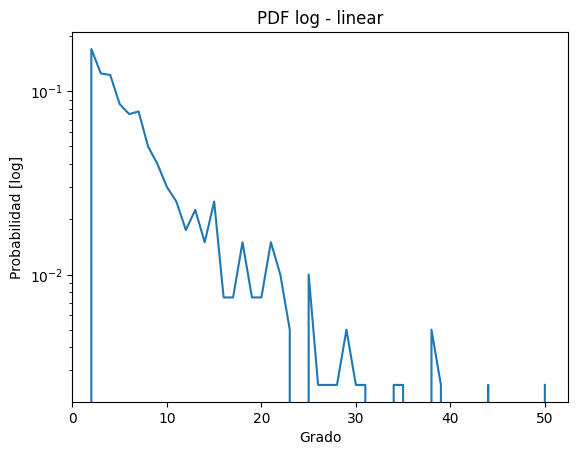

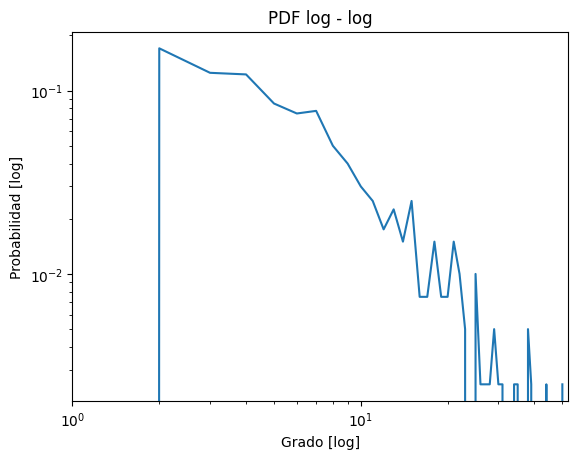

In [59]:
plot_pdf(pdf, grado_indice, x=None, y=None)
plot_pdf(pdf, grado_indice, x='log', y=None)
plot_pdf(pdf, grado_indice, x=None, y='log')
plot_pdf(pdf, grado_indice, x='log', y='log')

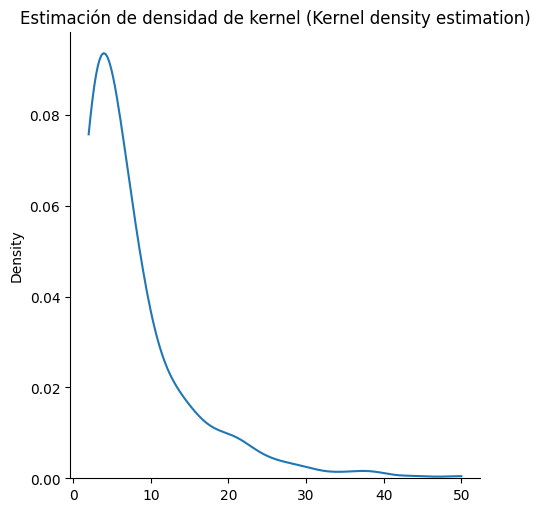

In [60]:
# Kernel density estimation:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    sns.displot(degrees, kind="kde", cut=0)
    plt.title('Estimación de densidad de kernel (Kernel density estimation)')
    plt.show()

plot_degree_dist(subgrafo)

### 3.5. Función de distribución de probabilidad acomulada empírica (empirical cumulative distribution function) (ECDF)

In [62]:
def plot_ecdf(ecdf, grado_indice, x=None, y=None):
    grid = sns.lineplot(x=grado_indice, y=ecdf)
    grid.set(xlim=0)

    if x=='log' and y=='log':
        grid.set(xscale="log", yscale="log")
        plt.xlabel('Grado [log]')
        plt.ylabel('Probabilidad [log]')
        plt.title('ECDF log - log')

    elif x=='log':
        grid.set(xscale="log")
        plt.xlabel('Grado [log]')
        plt.ylabel('Probabilidad')
        plt.title('ECDF linear - log')
    elif y=='log':
        grid.set(yscale="log")
        plt.xlabel('Grado')
        plt.ylabel('Probabilidad [log]')
        plt.title('ECDF log - linear')
    else:
        plt.xlabel('Grado')
        plt.ylabel('Probabilidad')
        plt.title('ECDF')
    grid.set(xlim=0)
    plt.show()

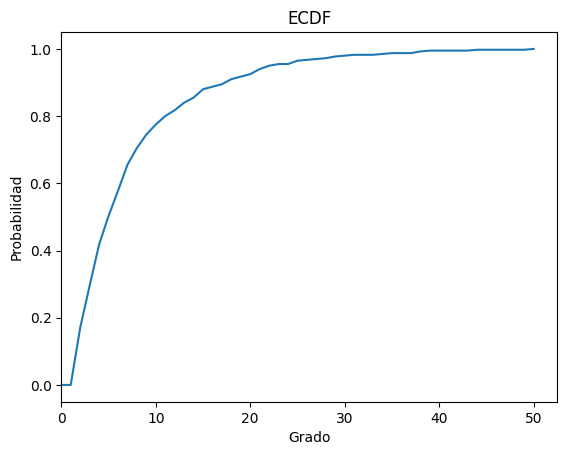

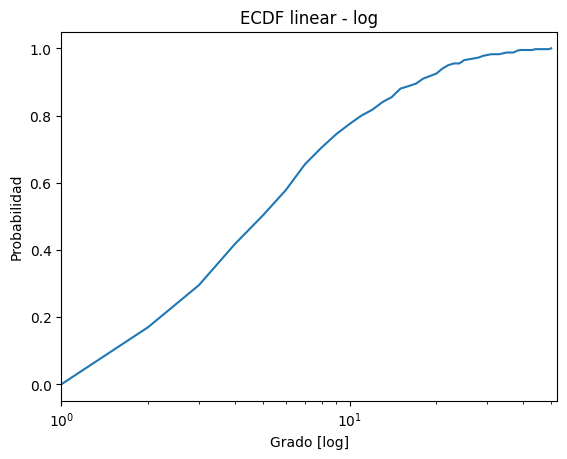

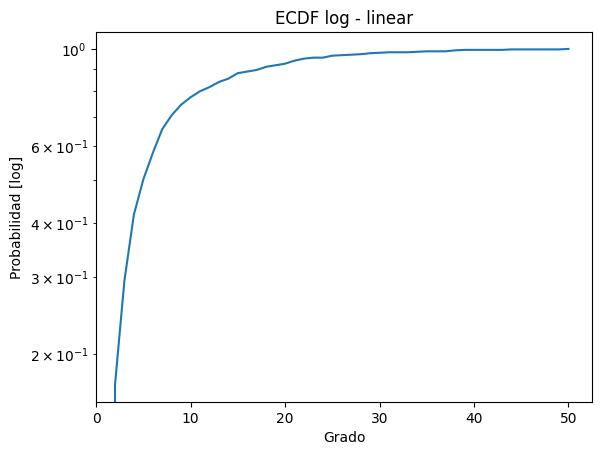

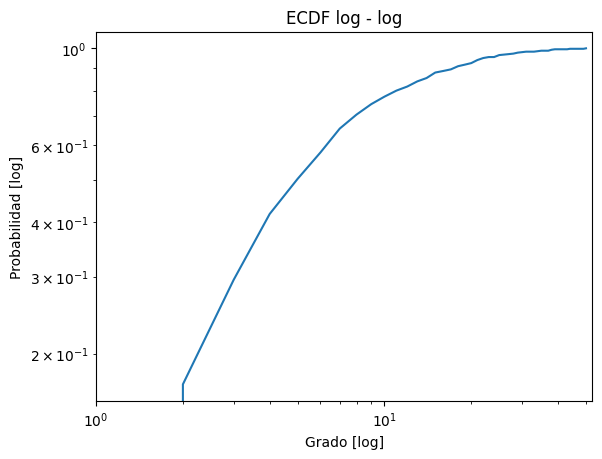

In [63]:
plot_ecdf(ecdf, grado_indice, x=None, y=None)
plot_ecdf(ecdf, grado_indice, x='log', y=None)
plot_ecdf(ecdf, grado_indice, x=None, y='log')
plot_ecdf(ecdf, grado_indice, x='log', y='log')

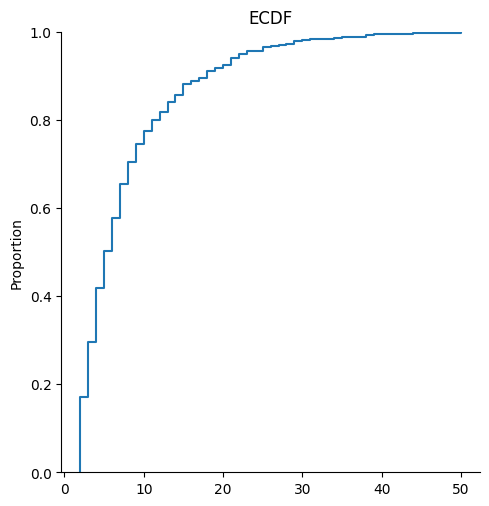

In [64]:
# Kernel density estimation:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    sns.displot(degrees, kind="ecdf")
    plt.title('ECDF')
    plt.show()

plot_degree_dist(subgrafo)

# Red Neuronal de Grafos (Graph Neural Network)

Node classification

In [13]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [14]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(train_dataset.num_features, 256, heads=4)
        self.lin1 = torch.nn.Linear(train_dataset.num_features, 4 * 256)
        self.conv2 = GATConv(4 * 256, 256, heads=4)
        self.lin2 = torch.nn.Linear(4 * 256, 4 * 256)
        self.conv3 = GATConv(4 * 256, train_dataset.num_classes, heads=6,
                             concat=False)
        self.lin3 = torch.nn.Linear(4 * 256, train_dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index) + self.lin2(x))
        x = self.conv3(x, edge_index) + self.lin3(x)
        return x

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)

In [16]:
@torch.no_grad()
def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        out = model(data.x.to(device), data.edge_index.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

In [17]:
losses = []
for epoch in range(1, 101):
    loss = train()
    losses.append(loss)
    val_f1 = test(val_loader)
    test_f1 = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_f1:.4f}, '
          f'Test: {test_f1:.4f}')

Epoch: 001, Loss: 0.9147, Val: 0.4982, Test: 0.4997
Epoch: 002, Loss: 0.5344, Val: 0.5756, Test: 0.5835
Epoch: 003, Loss: 0.4878, Val: 0.5955, Test: 0.6083
Epoch: 004, Loss: 0.4429, Val: 0.6428, Test: 0.6598
Epoch: 005, Loss: 0.4065, Val: 0.6779, Test: 0.6983
Epoch: 006, Loss: 0.3623, Val: 0.7204, Test: 0.7435
Epoch: 007, Loss: 0.3174, Val: 0.7577, Test: 0.7837
Epoch: 008, Loss: 0.2786, Val: 0.7911, Test: 0.8183
Epoch: 009, Loss: 0.2440, Val: 0.8085, Test: 0.8372
Epoch: 010, Loss: 0.2108, Val: 0.8446, Test: 0.8716
Epoch: 011, Loss: 0.1780, Val: 0.8496, Test: 0.8783
Epoch: 012, Loss: 0.1569, Val: 0.8753, Test: 0.9041
Epoch: 013, Loss: 0.1372, Val: 0.8853, Test: 0.9139
Epoch: 014, Loss: 0.1150, Val: 0.9009, Test: 0.9281
Epoch: 015, Loss: 0.1070, Val: 0.9111, Test: 0.9361
Epoch: 016, Loss: 0.0931, Val: 0.9210, Test: 0.9450
Epoch: 017, Loss: 0.0784, Val: 0.9271, Test: 0.9503
Epoch: 018, Loss: 0.0719, Val: 0.9294, Test: 0.9516
Epoch: 019, Loss: 0.0677, Val: 0.9346, Test: 0.9557
Epoch: 020, 

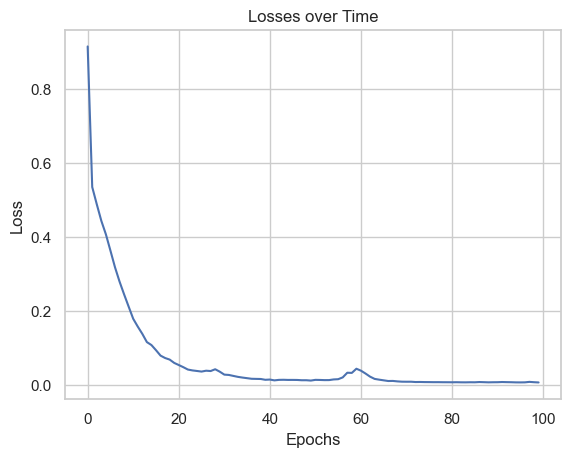

In [46]:
# Visualize learning (training loss)
loss_indices = [i for i,l in enumerate(losses)] 
sns.lineplot(x=loss_indices, y=losses, legend='auto')
plt.title('Perdidas en el Tiempo (Losses over Time)')
plt.xlabel('Epocas (Epochs)')
plt.ylabel('Perdidas (Loss)')
plt.show()

### Mostrar las Predicciones (Plot predictions)

In [69]:
# Para solo un batch (just one batch)
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    # Add sigmoid:
    pred = torch.sigmoid(model(test_batch.x.to(device), test_batch.edge_index.to(device)))
    # Get predictions 1 or 0:
    pred = (pred>0.5).float()

In [81]:
y_true = test_batch.y.numpy()
y_true.shape

(5524, 121)

In [82]:
y_pred = pred.numpy()
y_pred.shape

(5524, 121)

### Matriz de confusión (Confusion Matrix) 

In [86]:
matriz_confusion = multilabel_confusion_matrix(y_true, pred)
print(matriz_confusion)

[[[1958   48]
  [  18 3500]]

 [[4219   12]
  [  22 1271]]

 [[4370   16]
  [  26 1112]]

 [[4206   16]
  [  16 1286]]

 [[4799    4]
  [  10  711]]

 [[4476    7]
  [  13 1028]]

 [[4194    9]
  [  18 1303]]

 [[3587   21]
  [  19 1897]]

 [[4641    5]
  [   8  870]]

 [[3585   13]
  [  12 1914]]

 [[4327    5]
  [   8 1184]]

 [[4264   15]
  [  30 1215]]

 [[1615   45]
  [  30 3834]]

 [[4512   24]
  [  33  955]]

 [[4546    5]
  [  22  951]]

 [[3504   39]
  [  30 1951]]

 [[4958    5]
  [   8  553]]

 [[4736    7]
  [  35  746]]

 [[4066   17]
  [  33 1408]]

 [[3150   25]
  [  23 2326]]

 [[4470    5]
  [  13 1036]]

 [[2094   42]
  [  23 3365]]

 [[4292    6]
  [  20 1206]]

 [[3689   21]
  [  22 1792]]

 [[4606    7]
  [  11  900]]

 [[2032   32]
  [  37 3423]]

 [[1818   34]
  [  35 3637]]

 [[3680   21]
  [  19 1804]]

 [[1625   38]
  [  37 3824]]

 [[4596    2]
  [  25  901]]

 [[1793   46]
  [  23 3662]]

 [[4715   11]
  [  36  762]]

 [[ 599   30]
  [  10 4885]]

 [[4652   

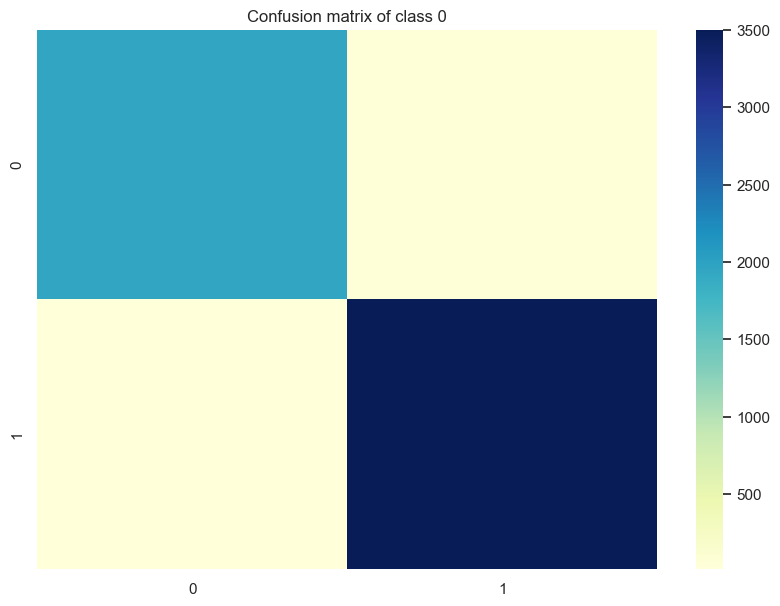

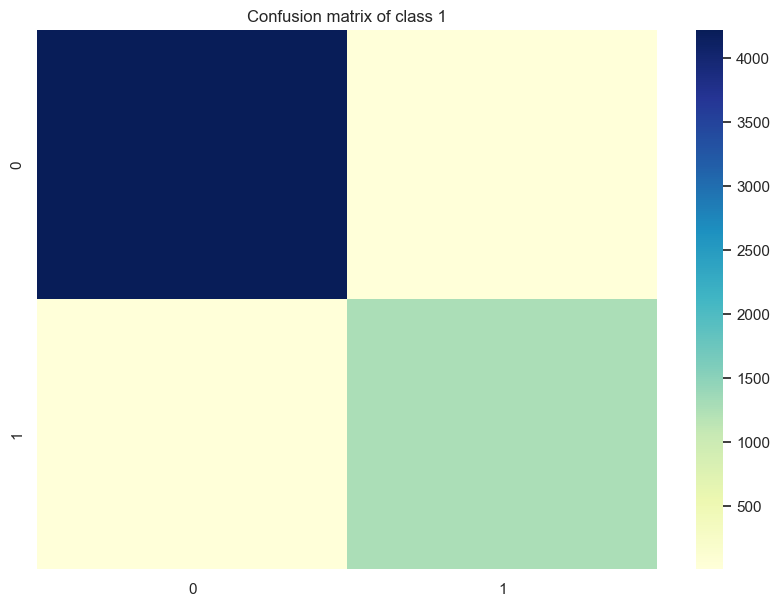

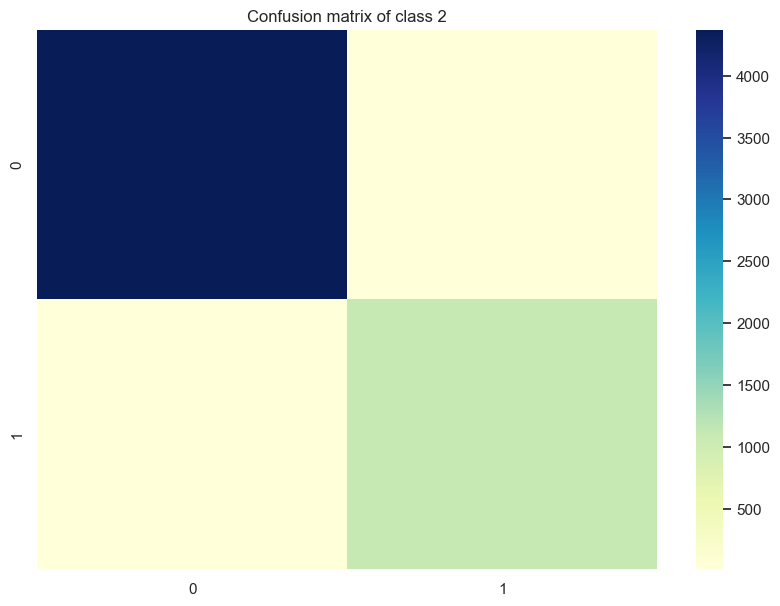

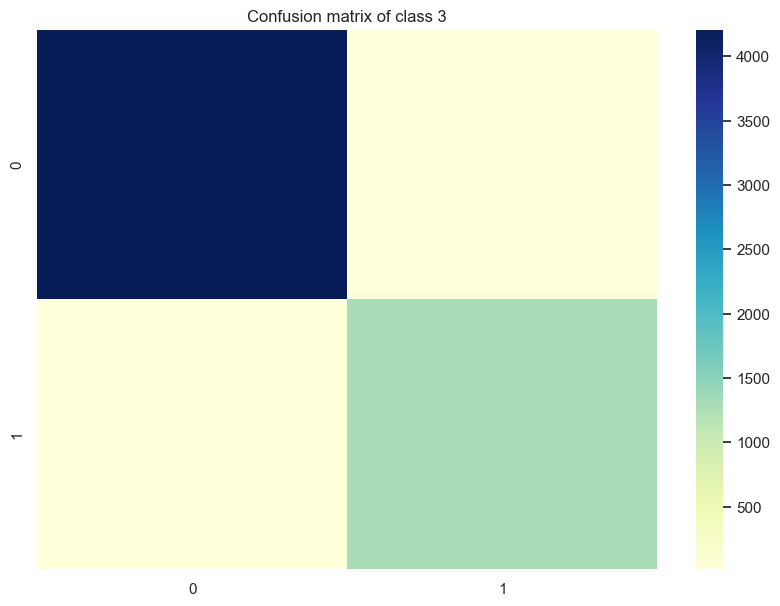

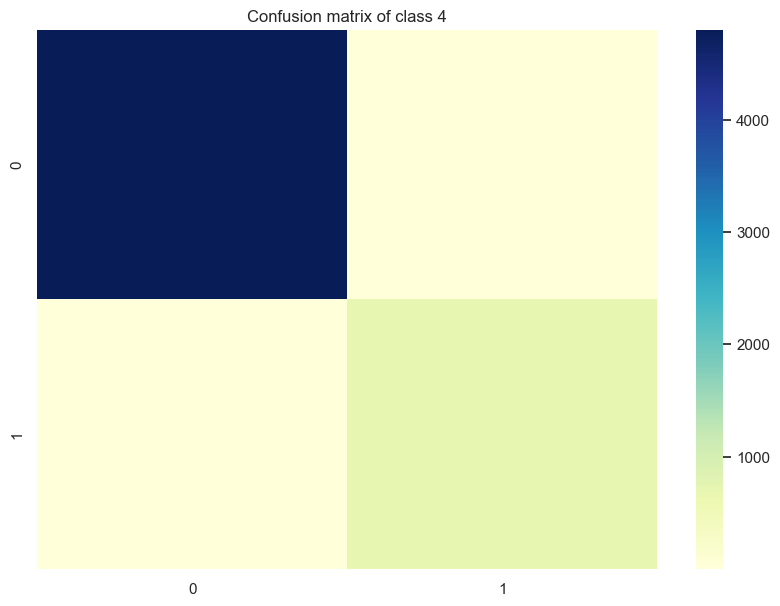

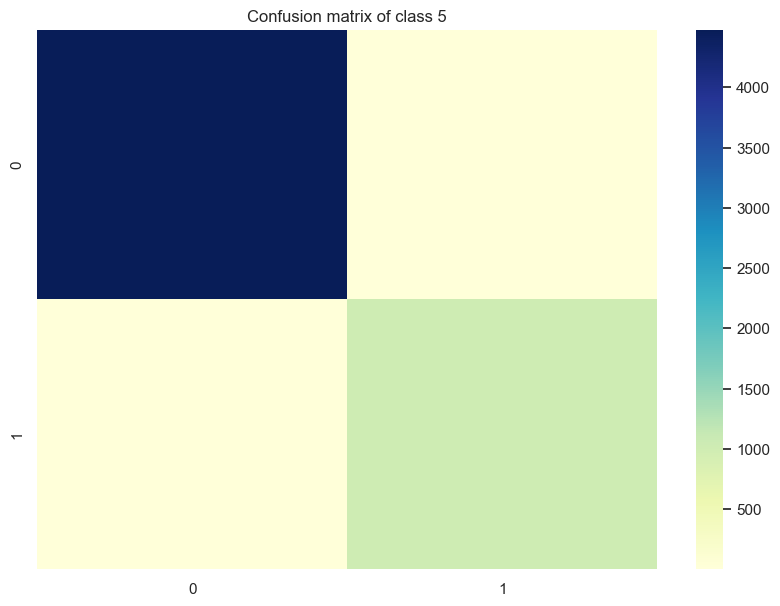

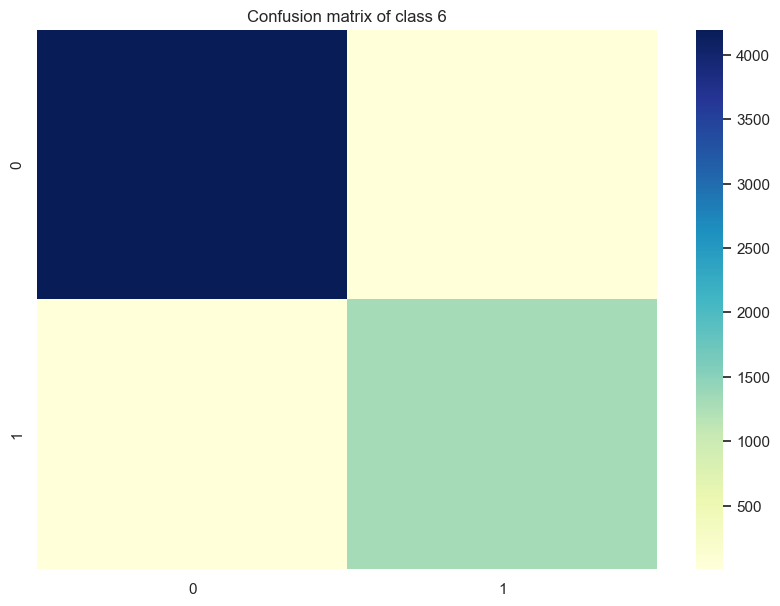

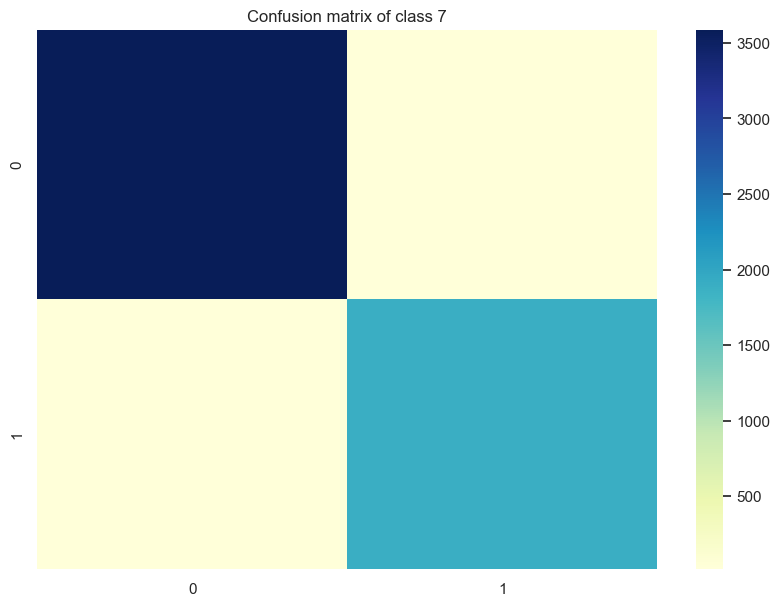

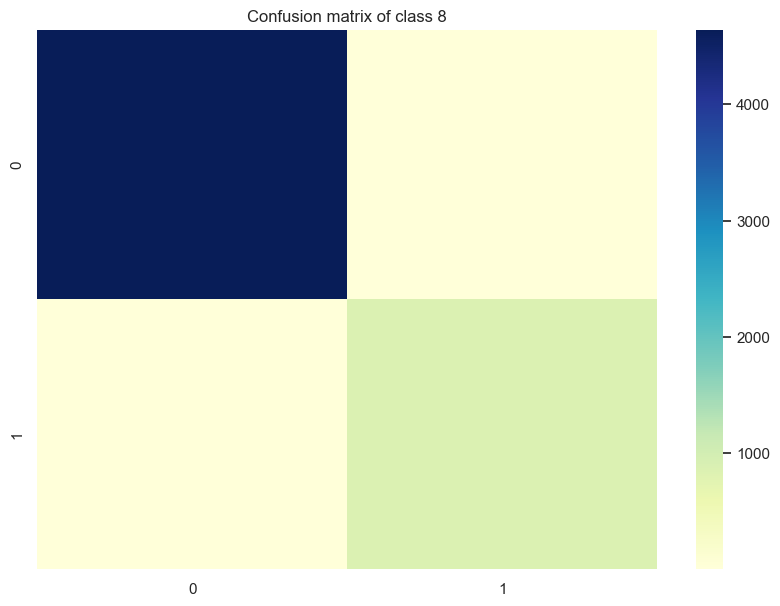

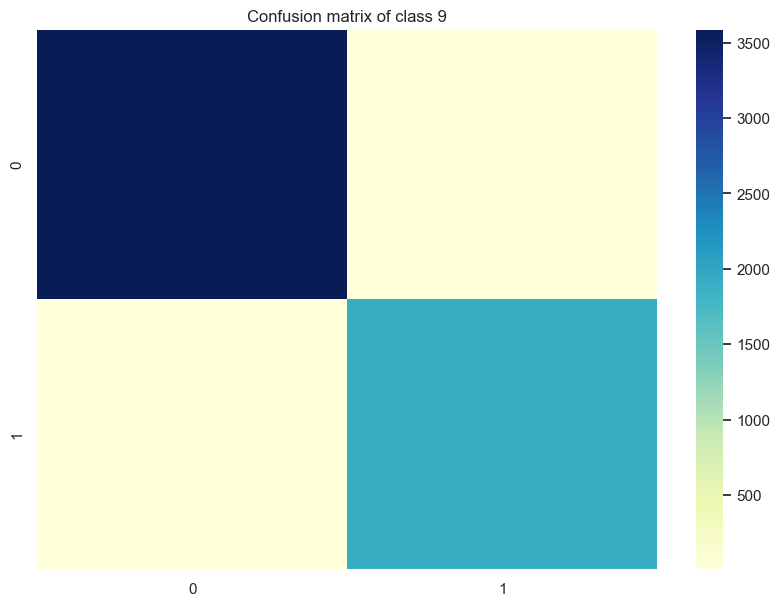

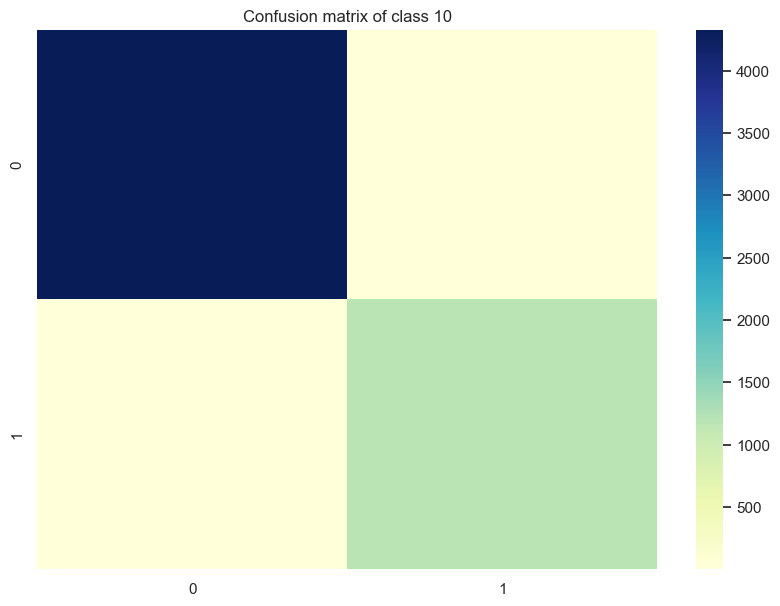

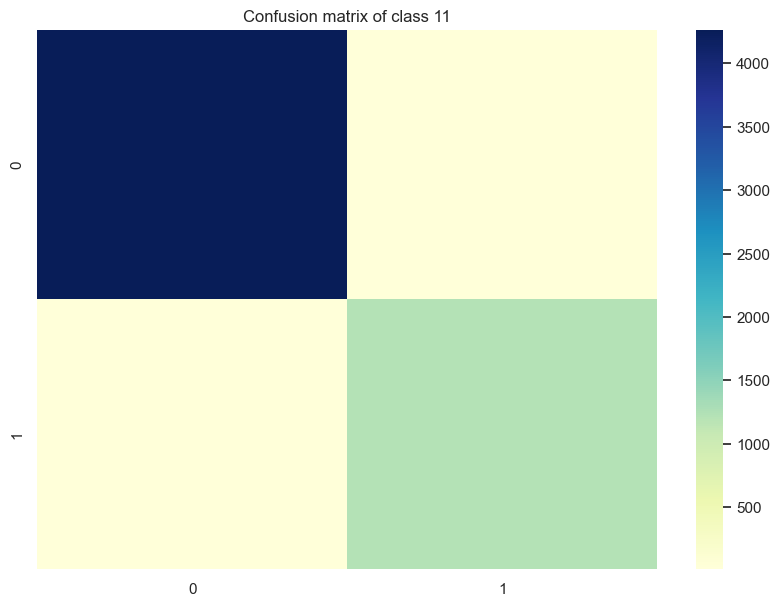

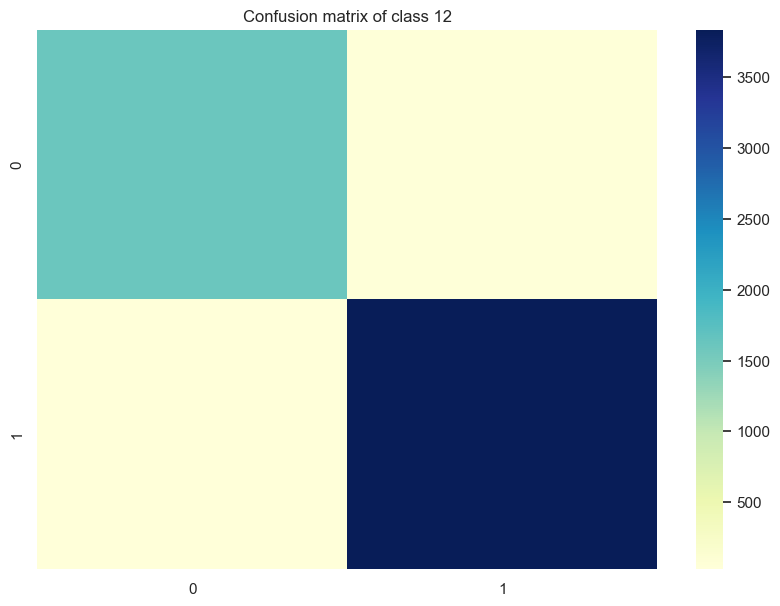

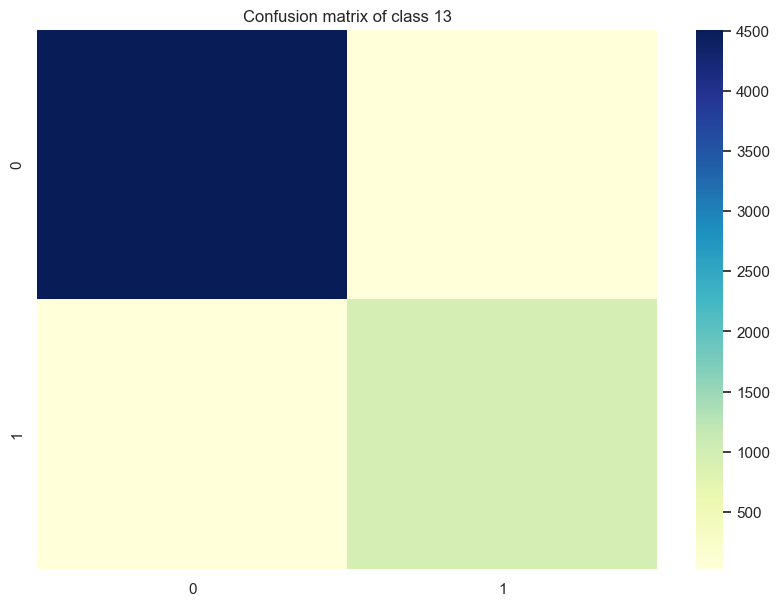

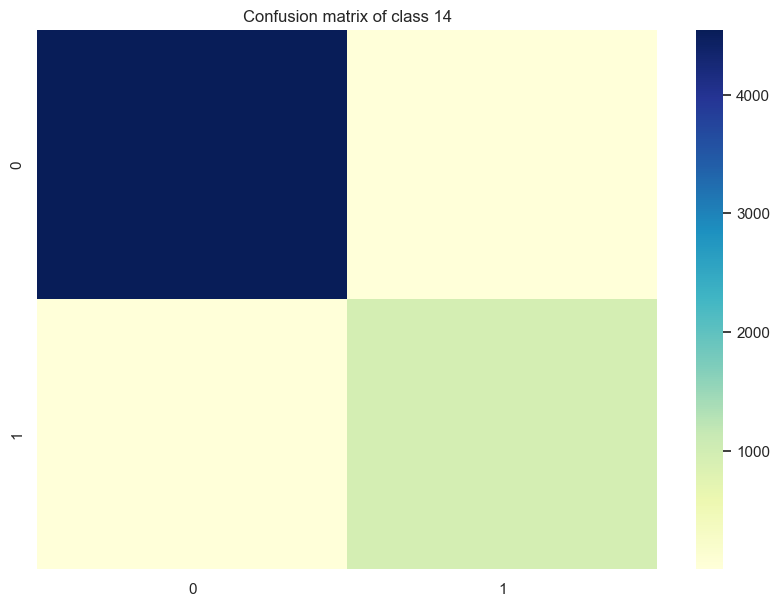

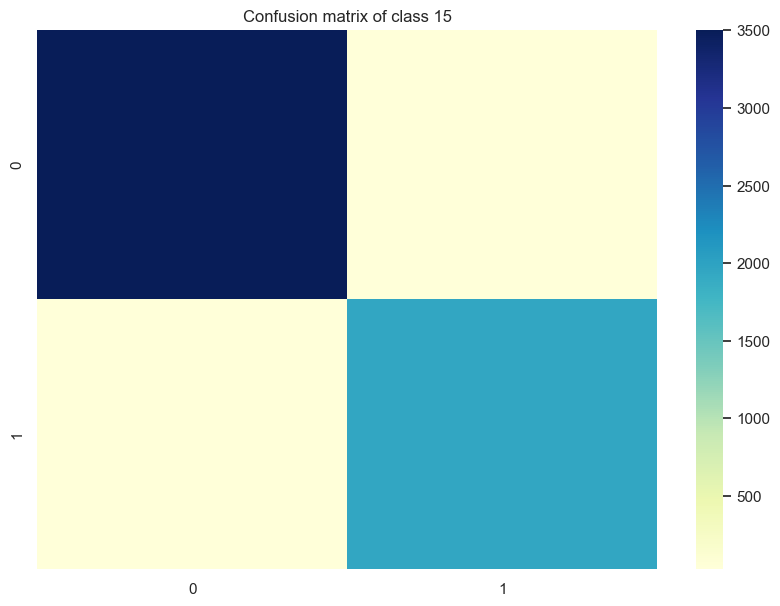

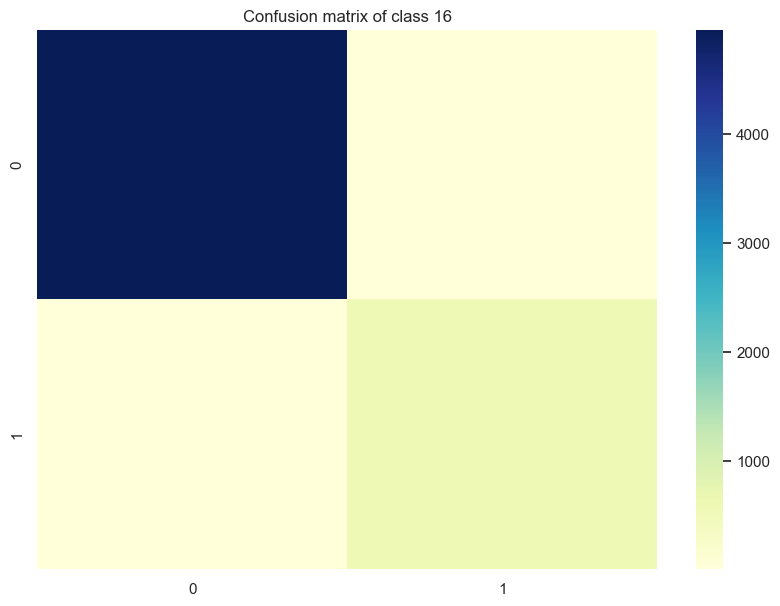

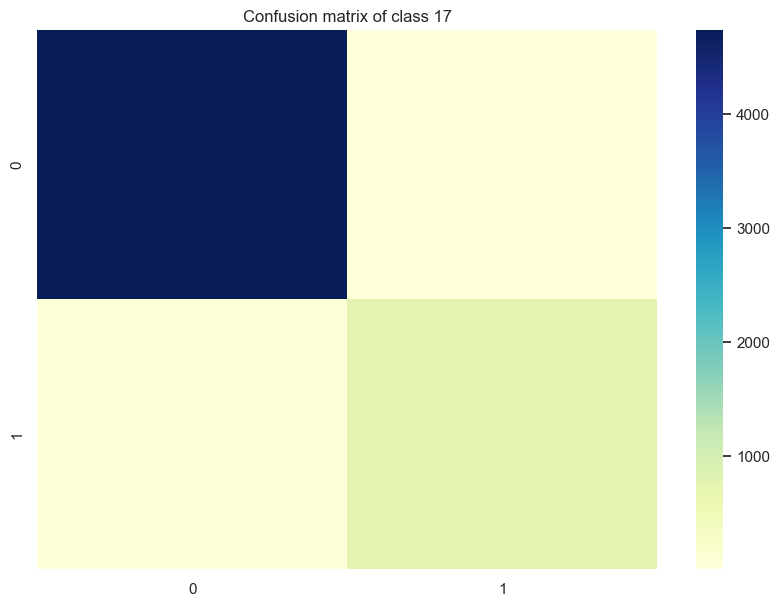

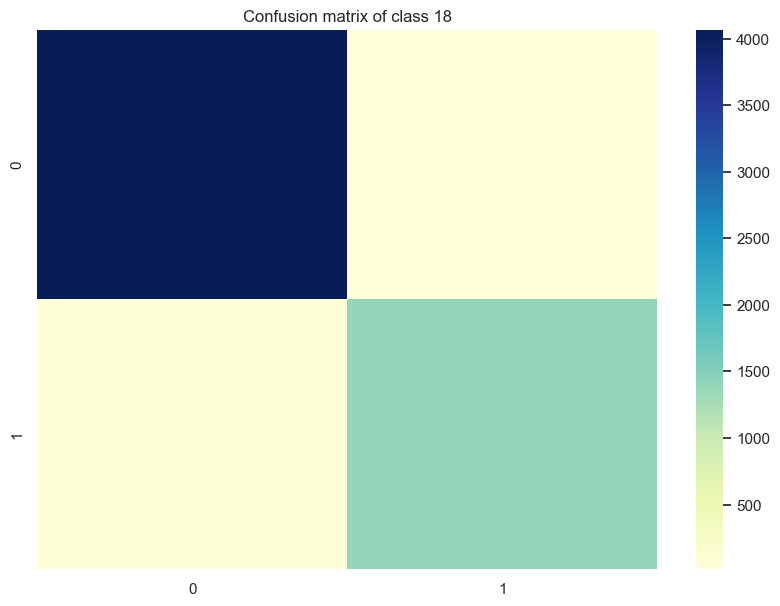

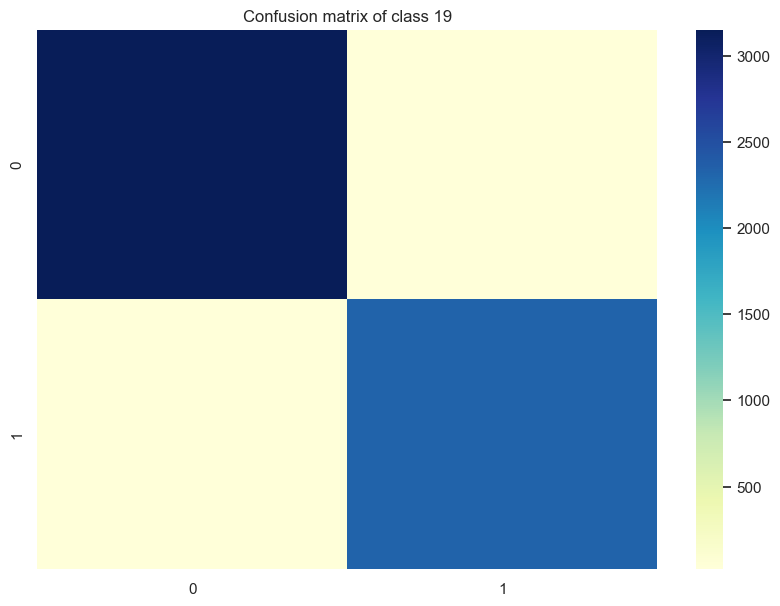

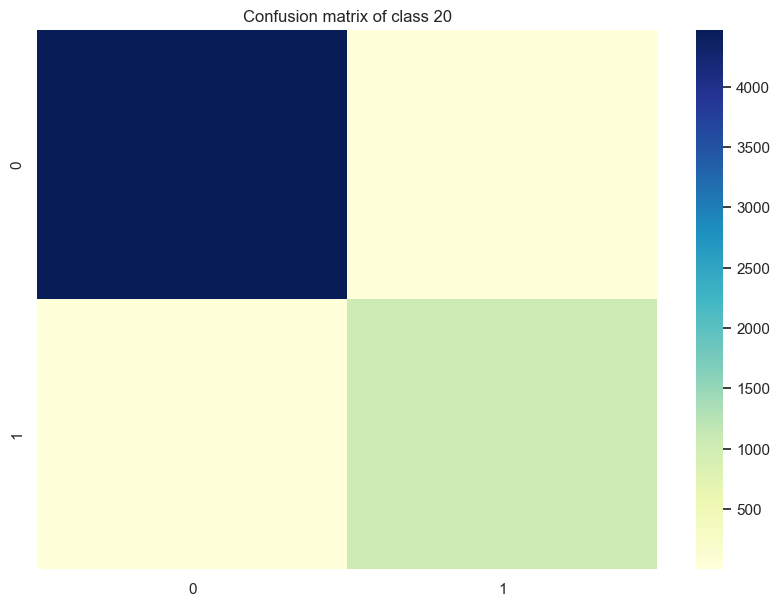

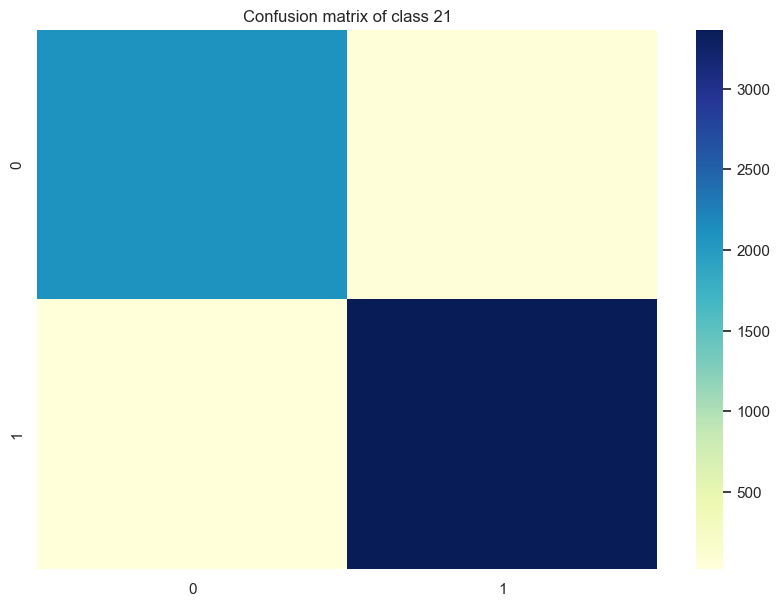

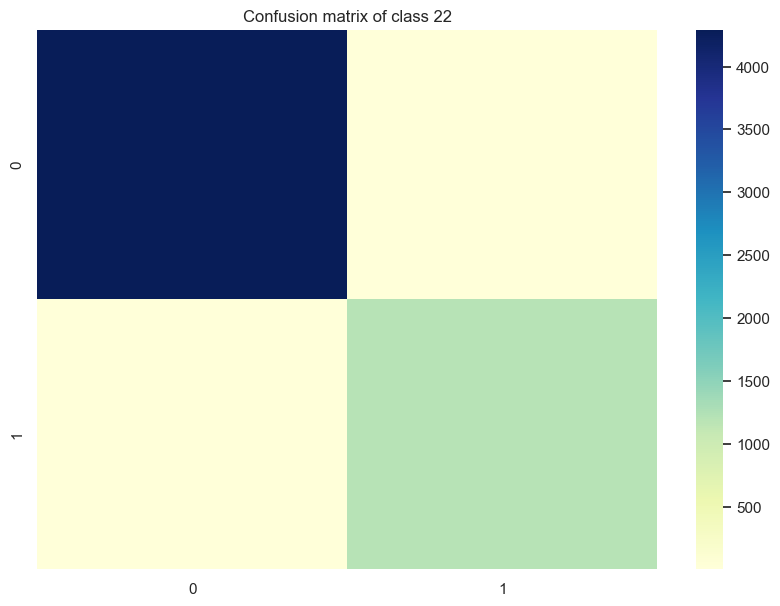

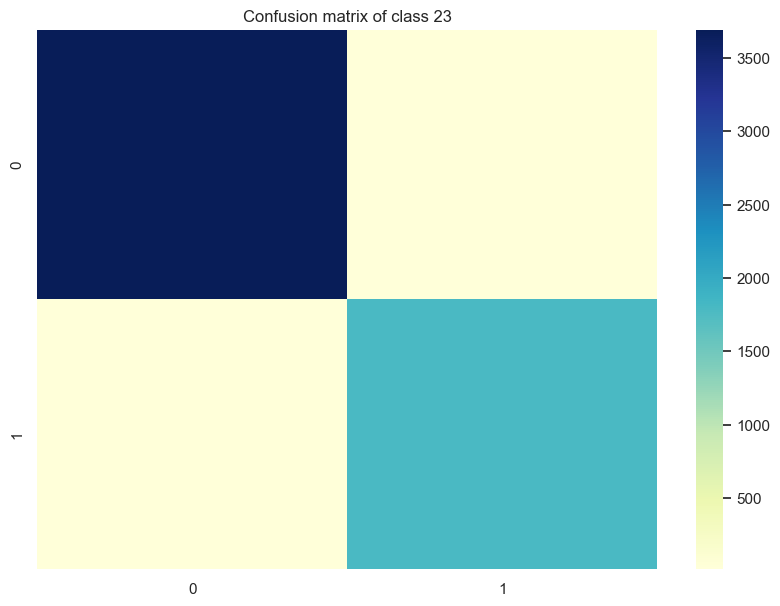

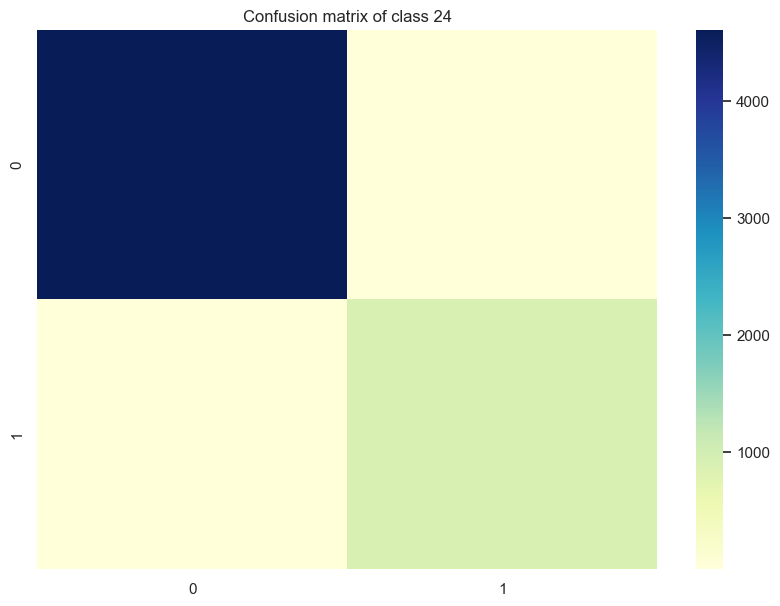

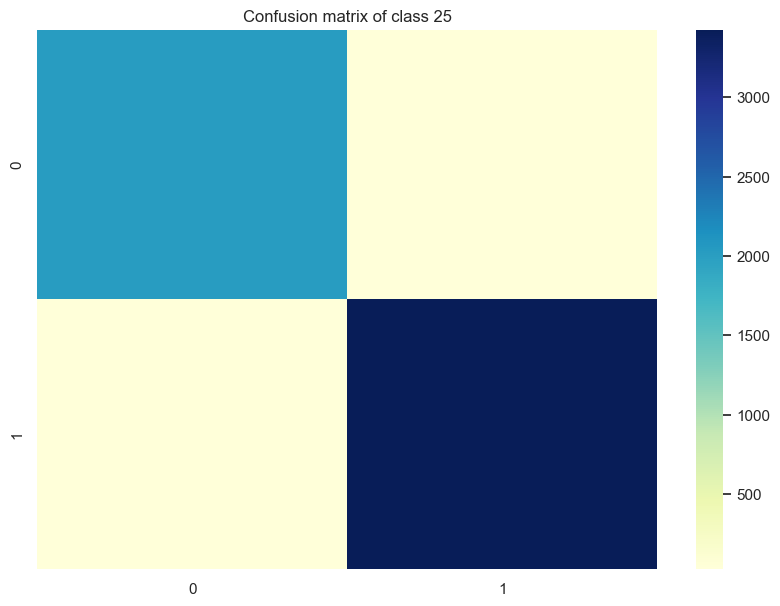

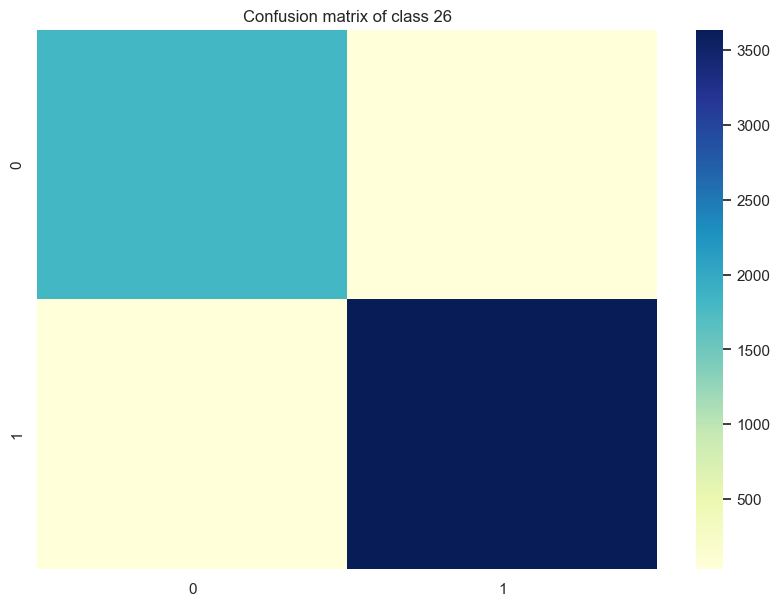

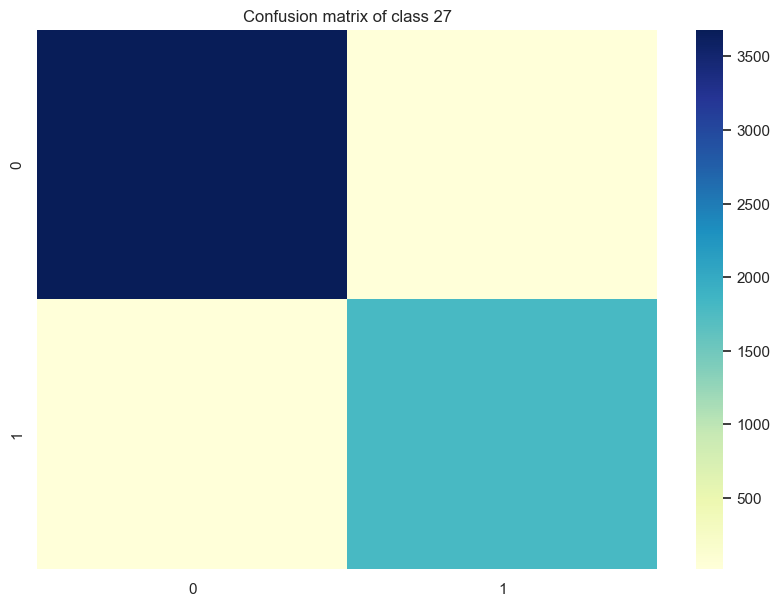

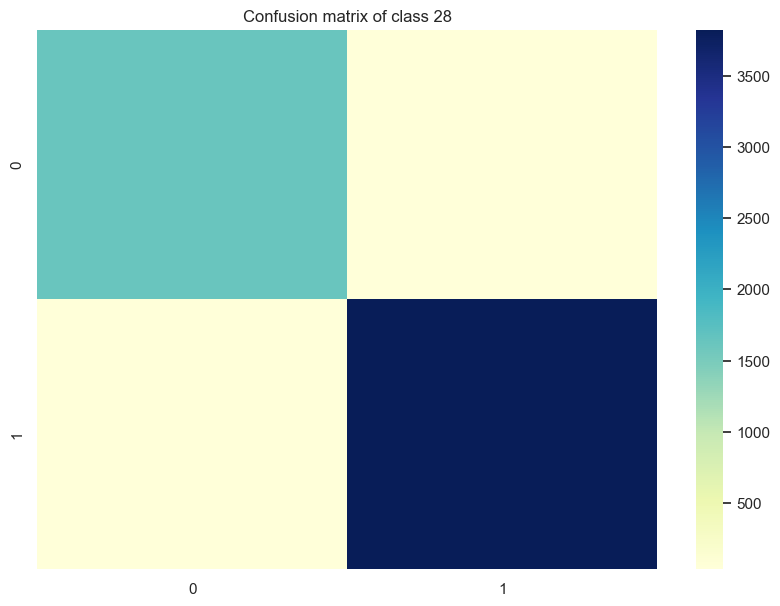

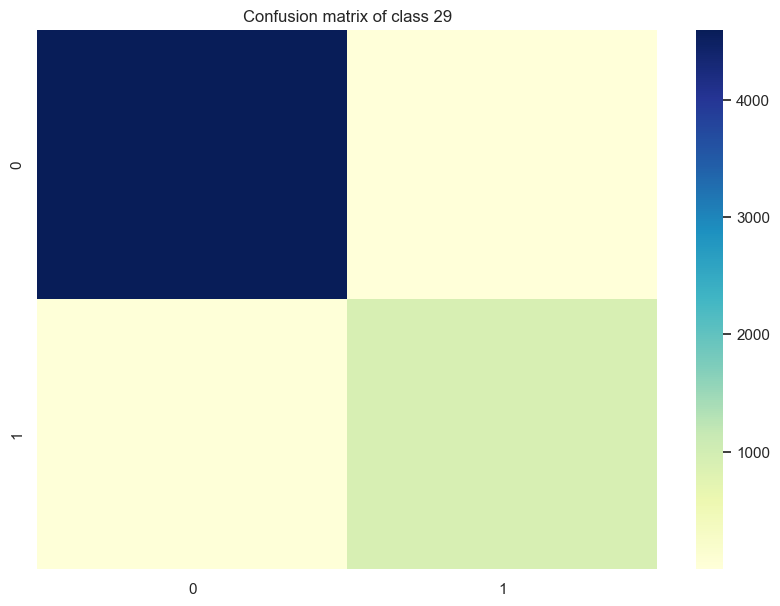

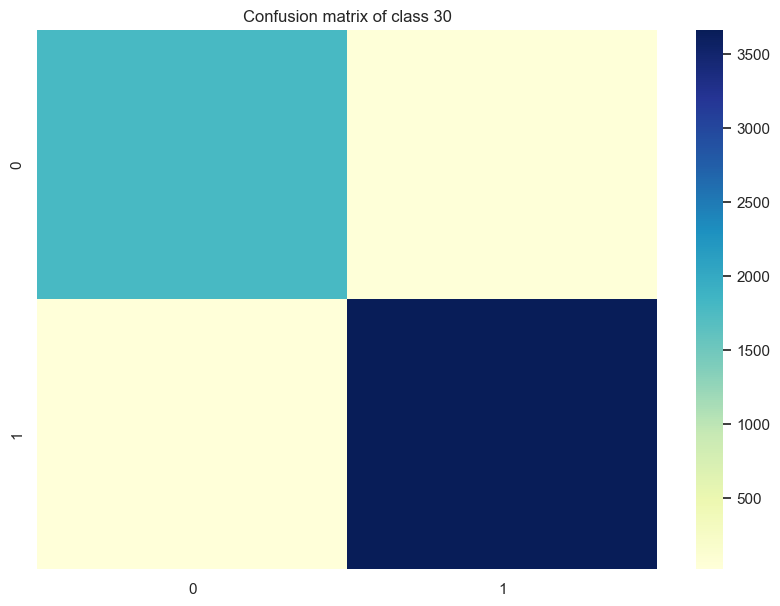

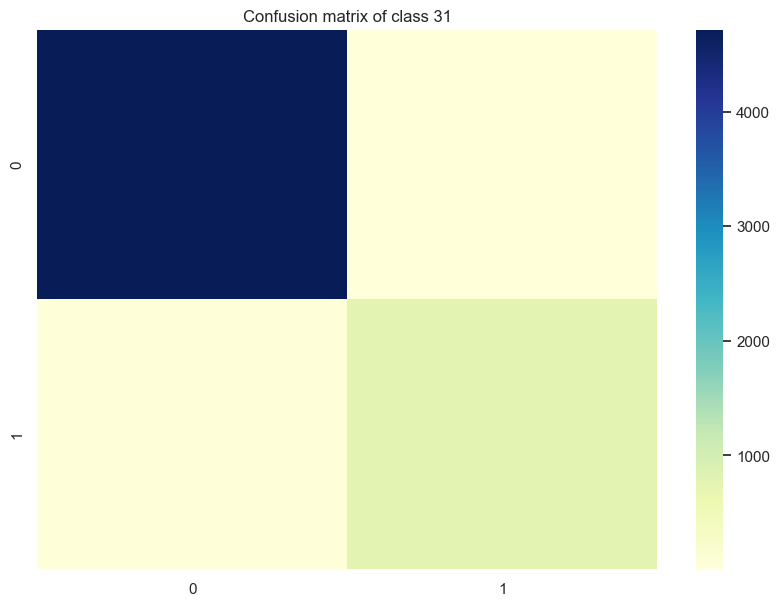

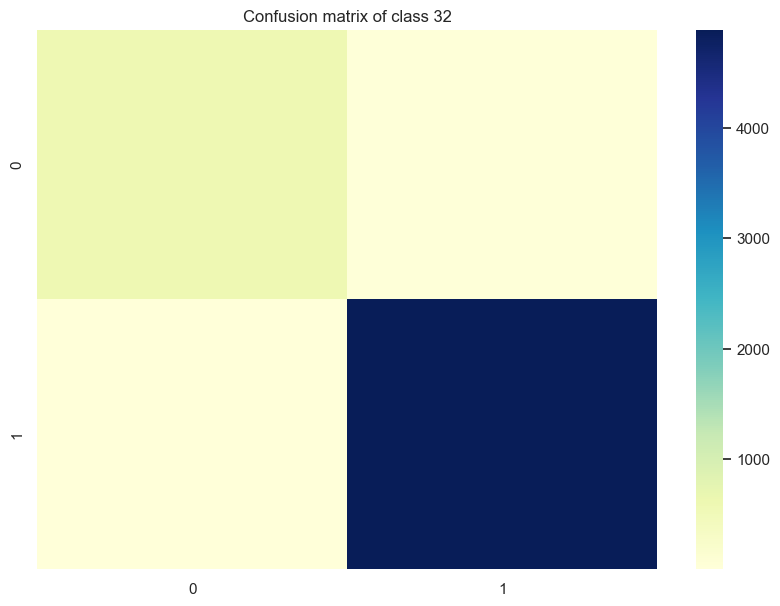

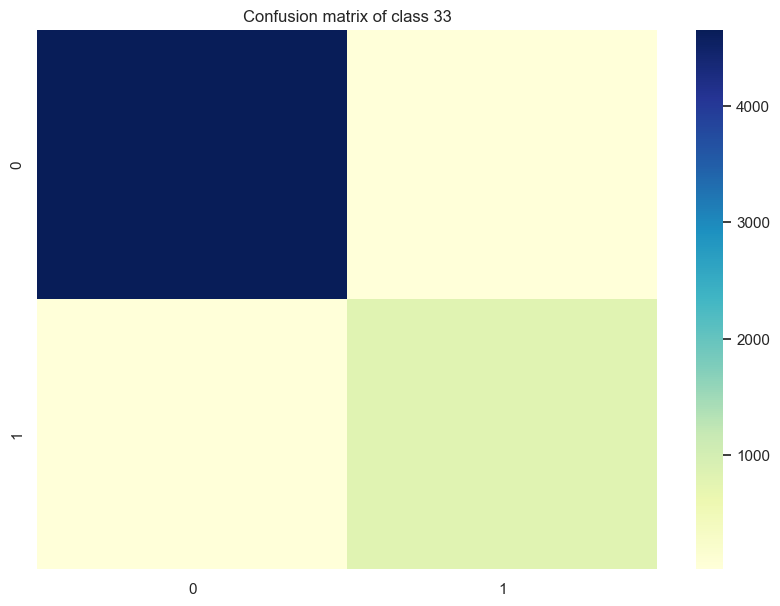

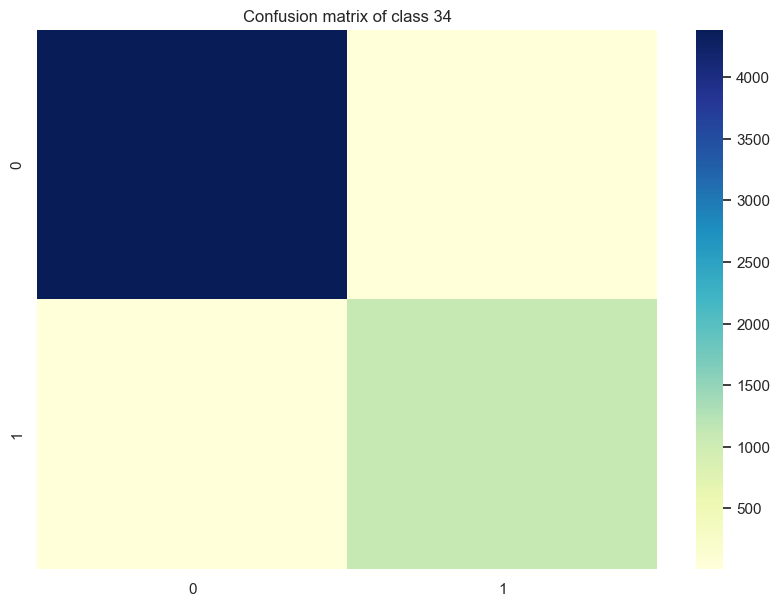

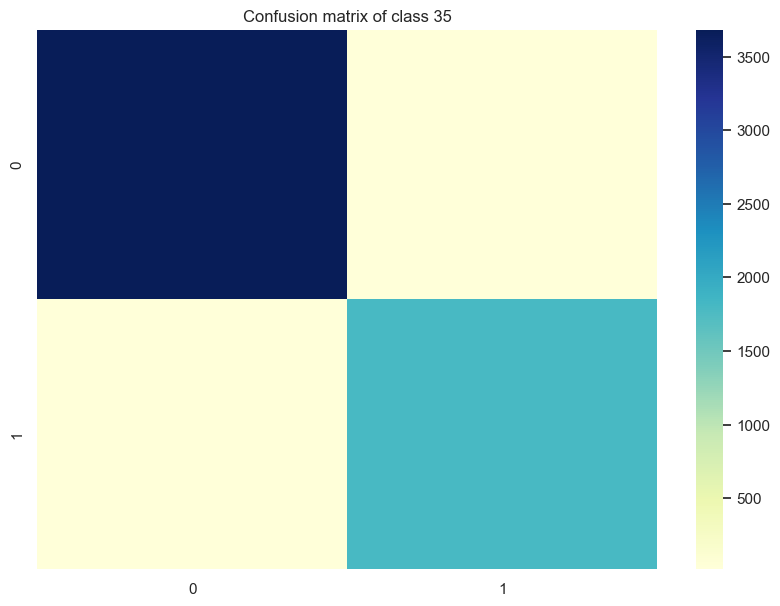

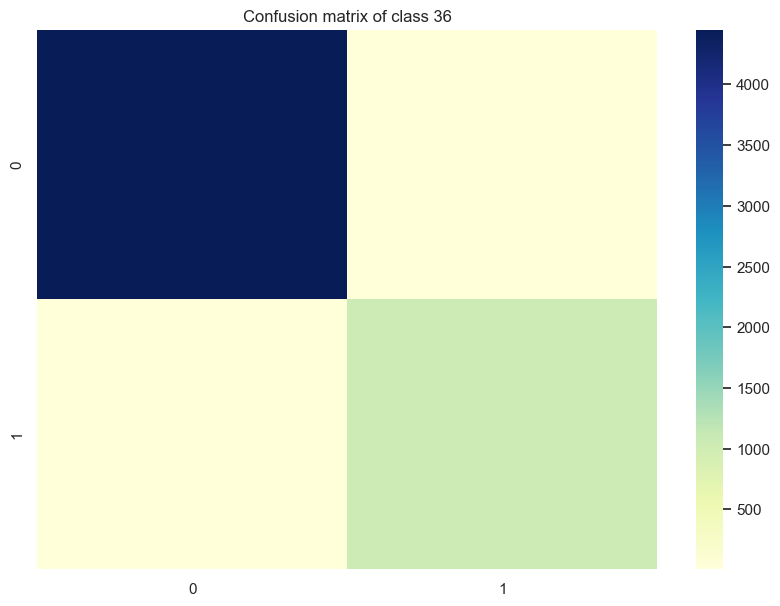

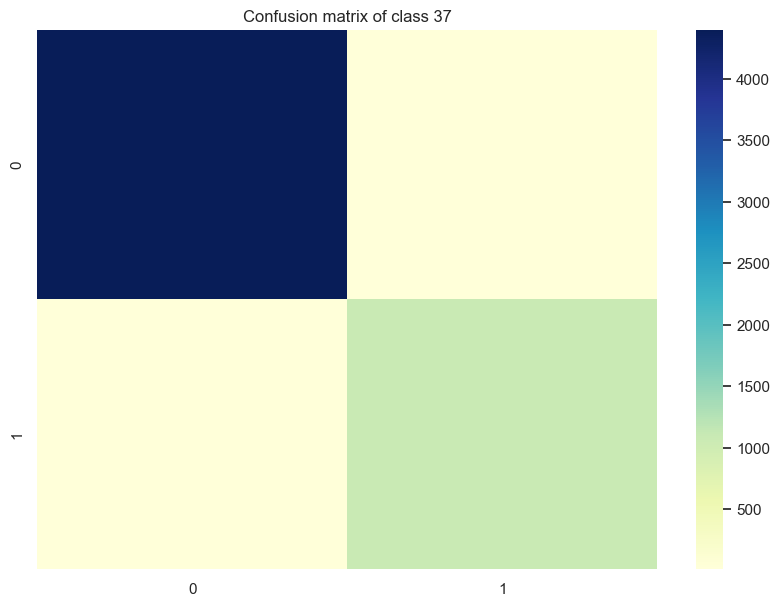

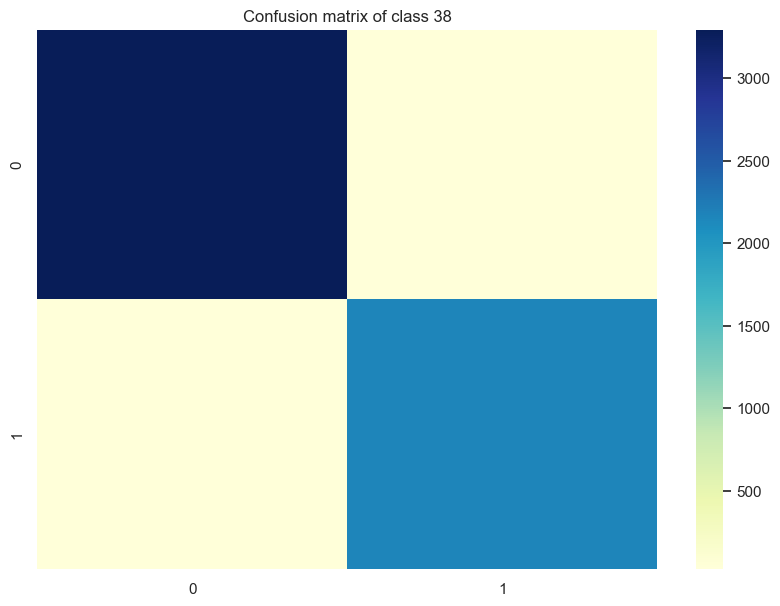

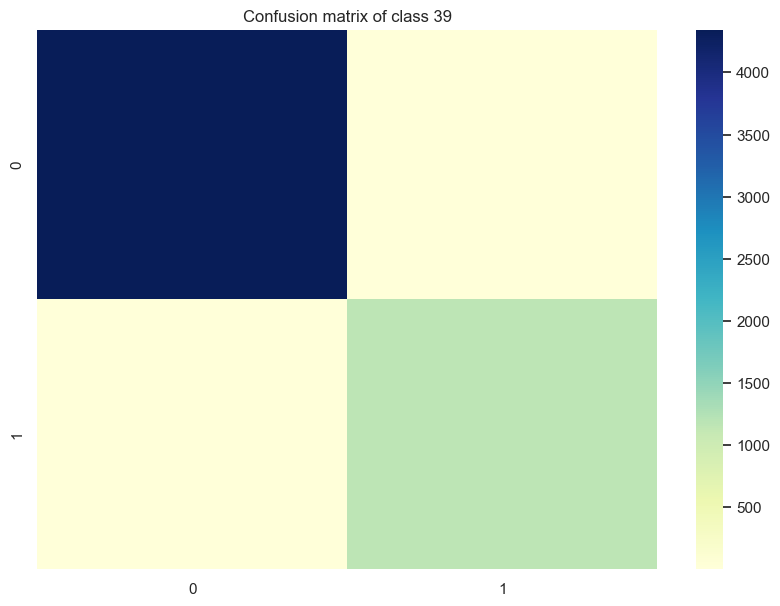

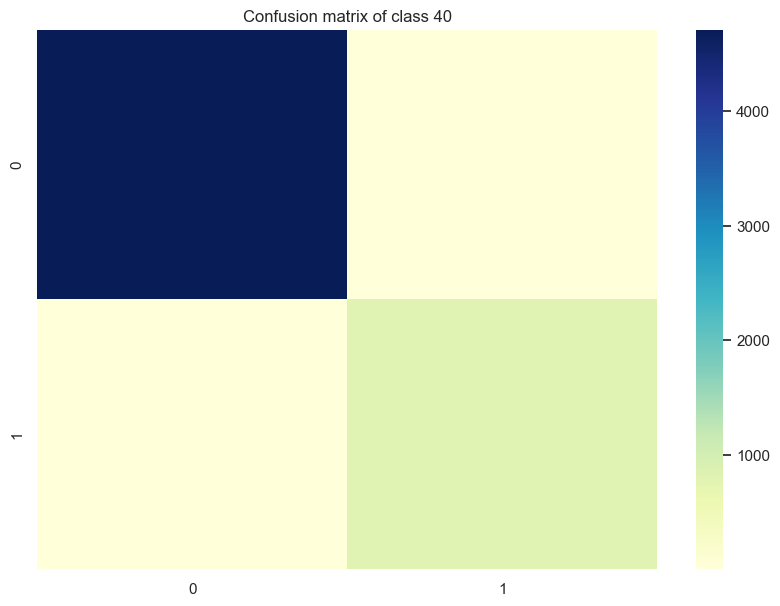

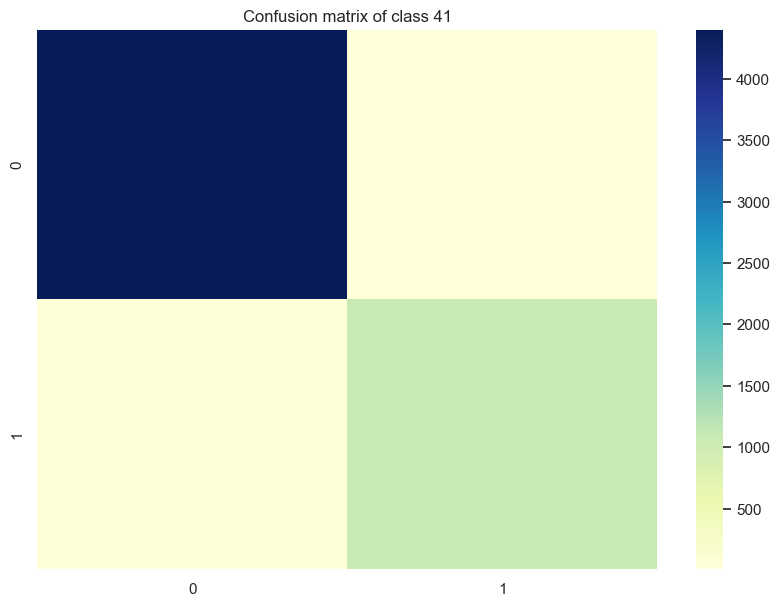

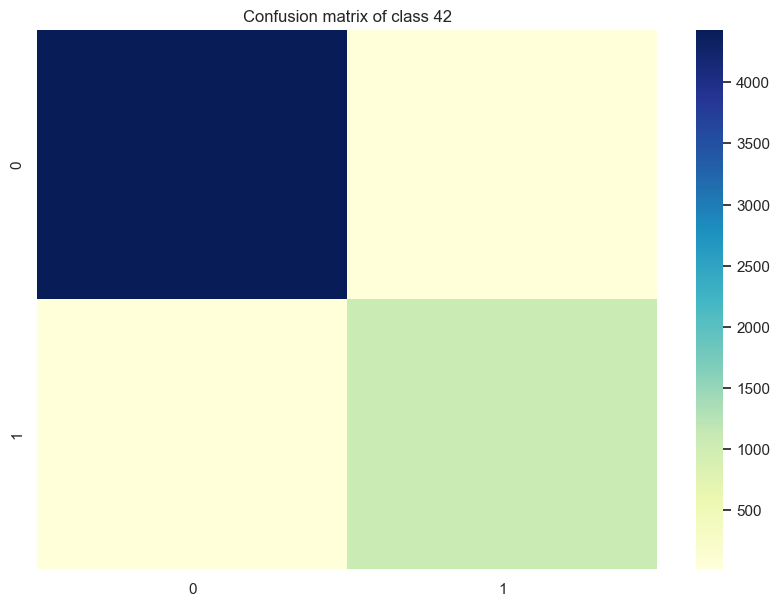

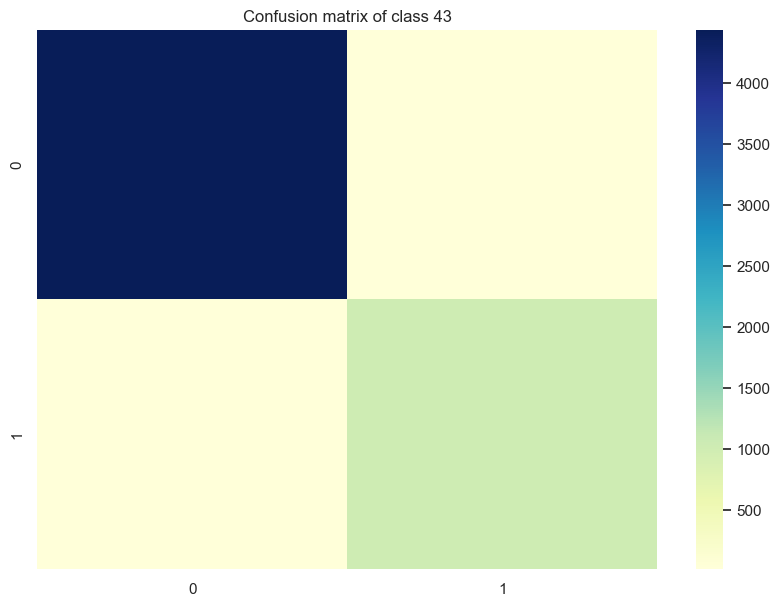

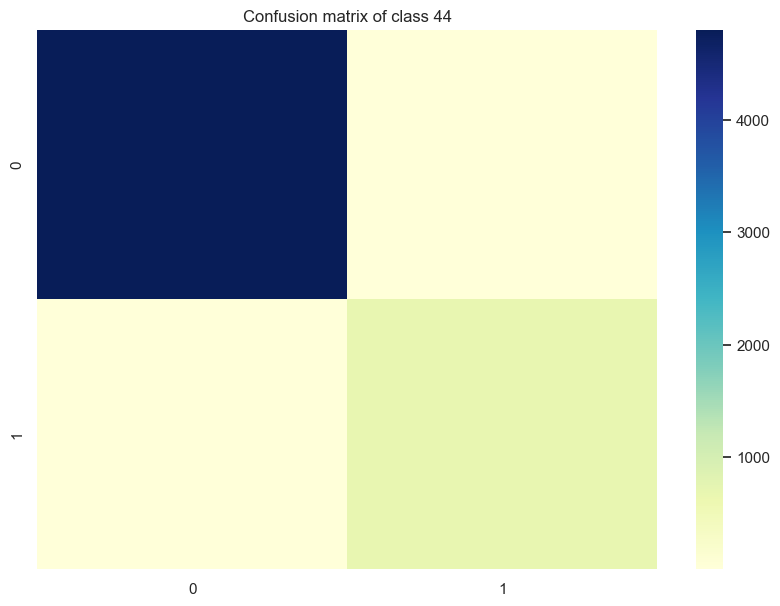

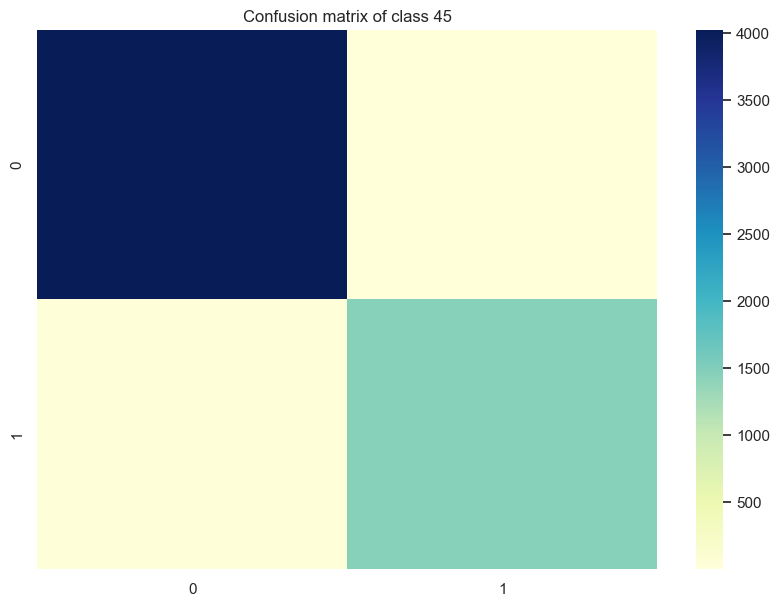

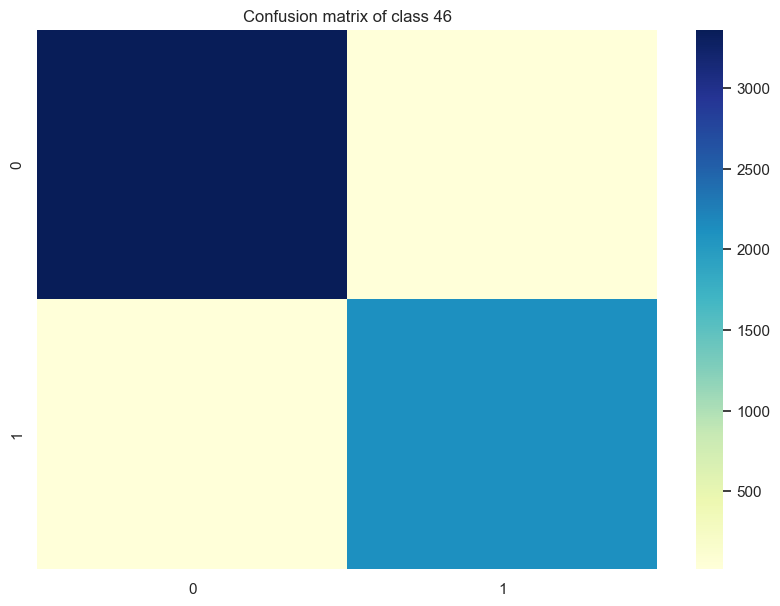

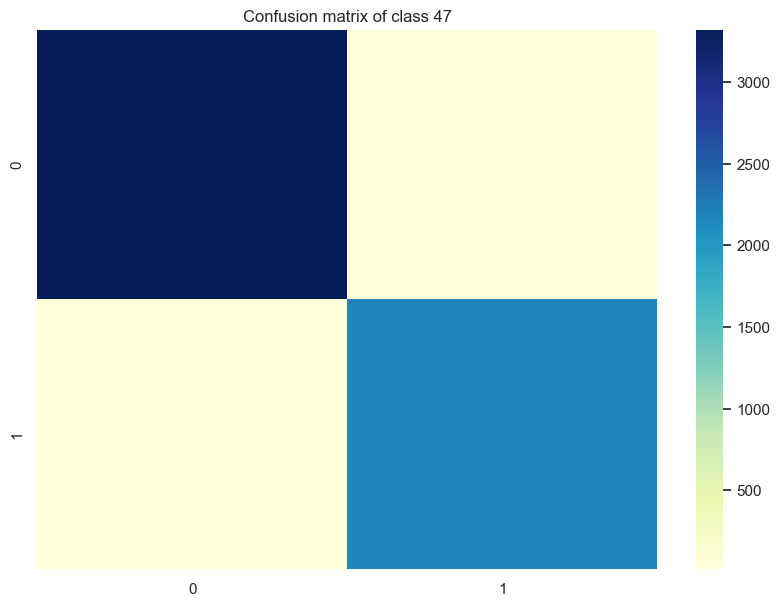

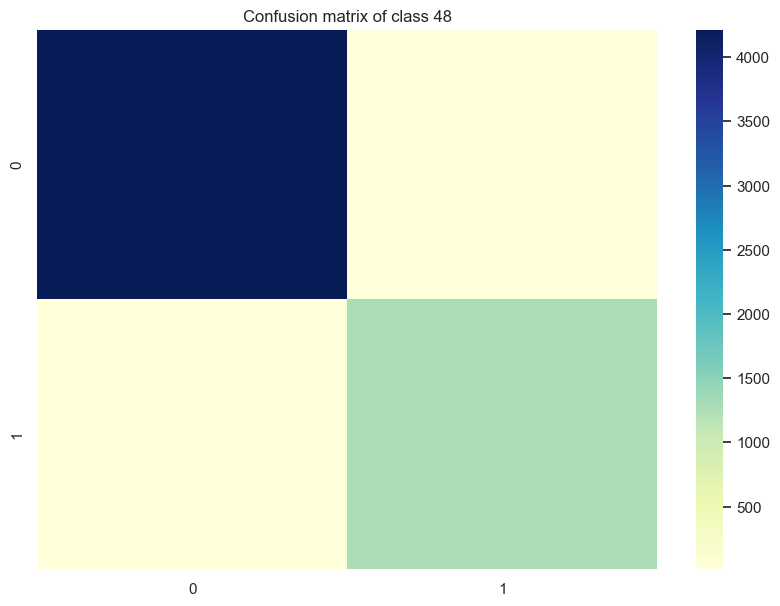

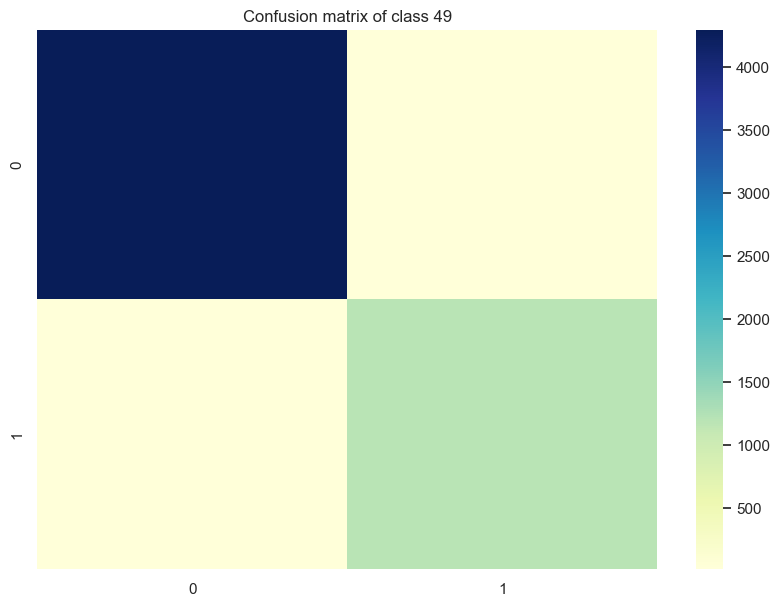

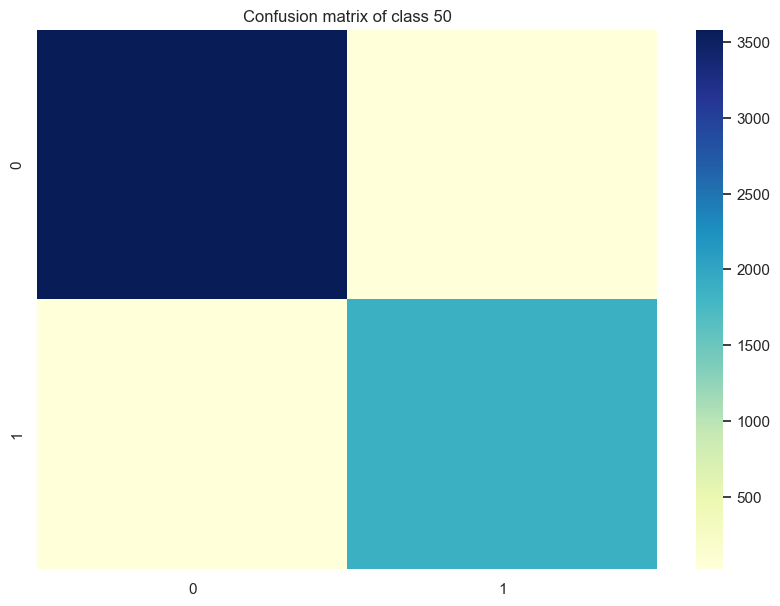

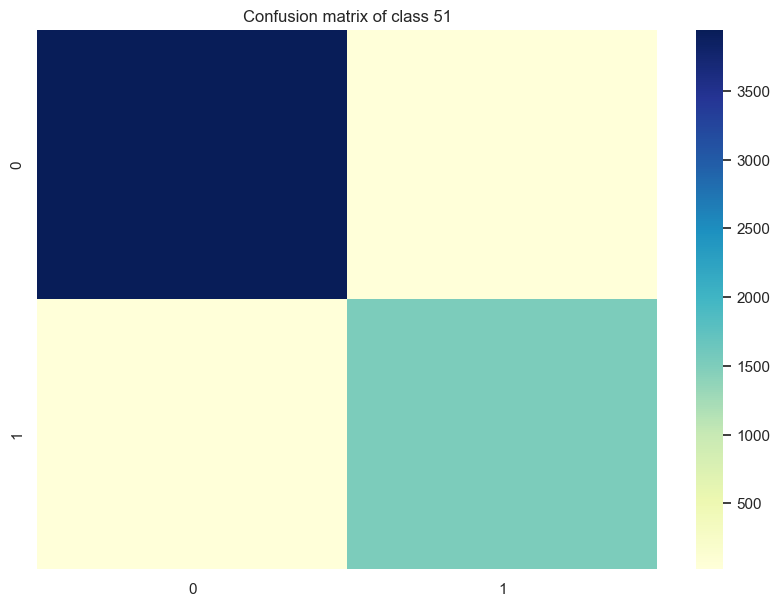

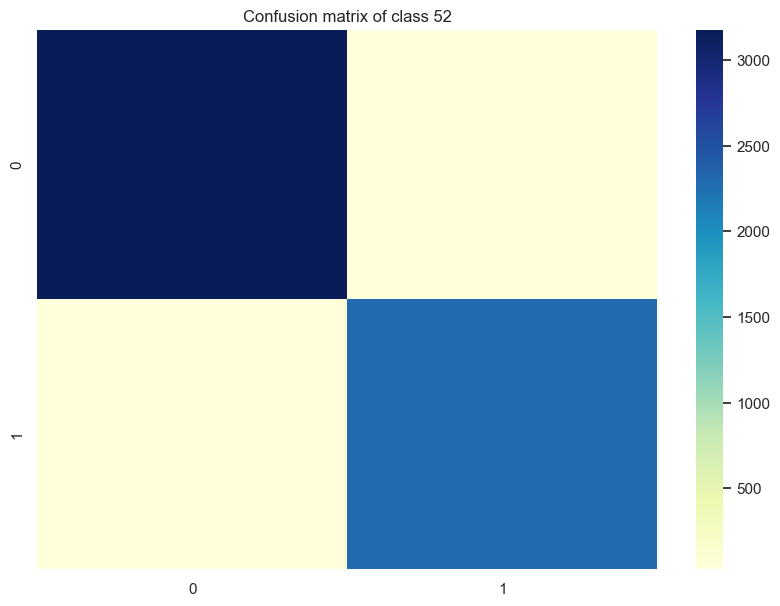

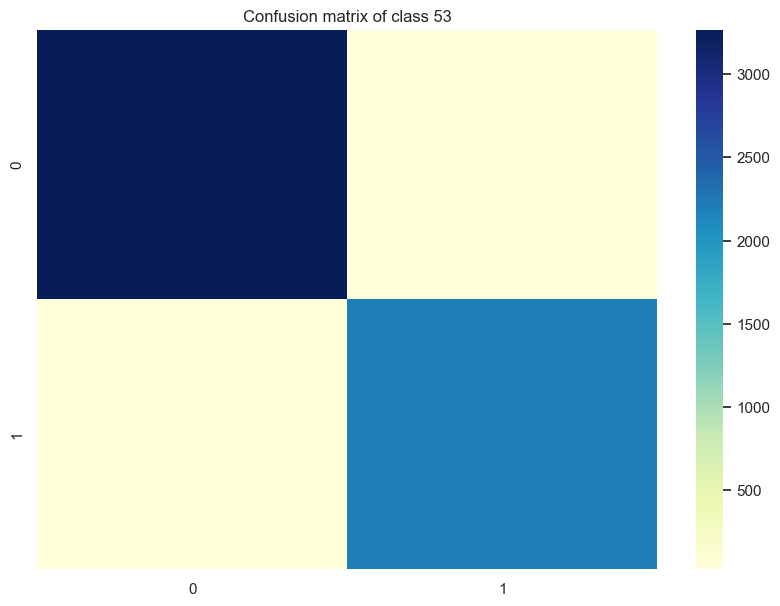

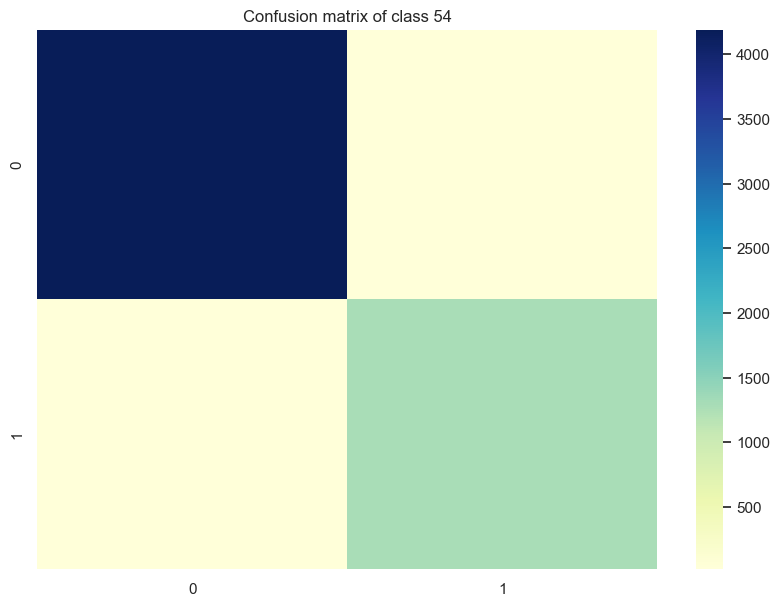

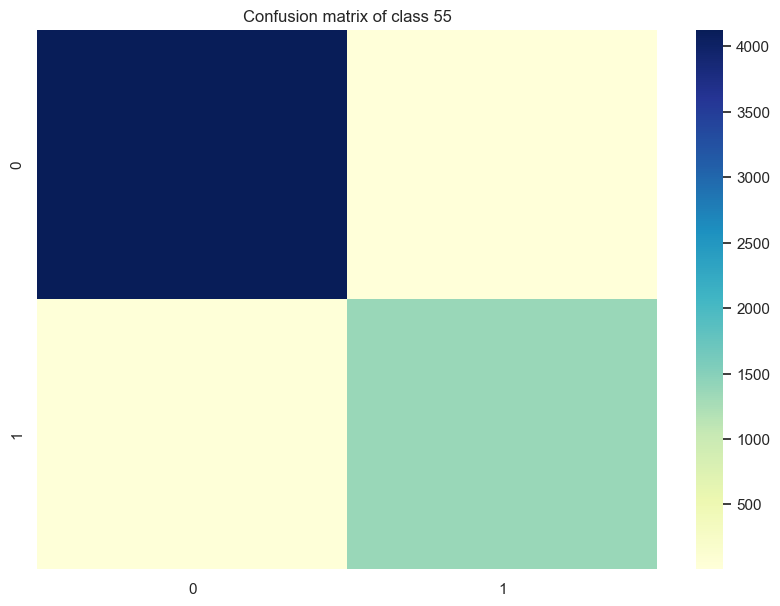

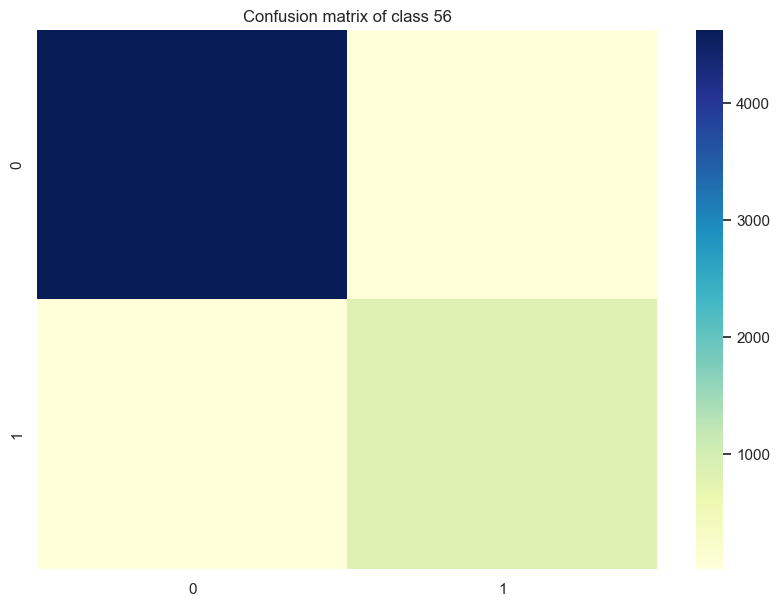

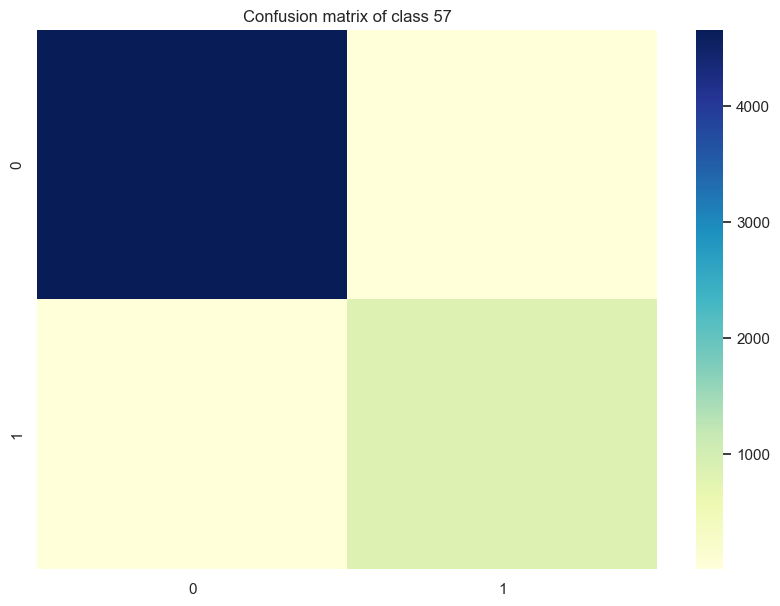

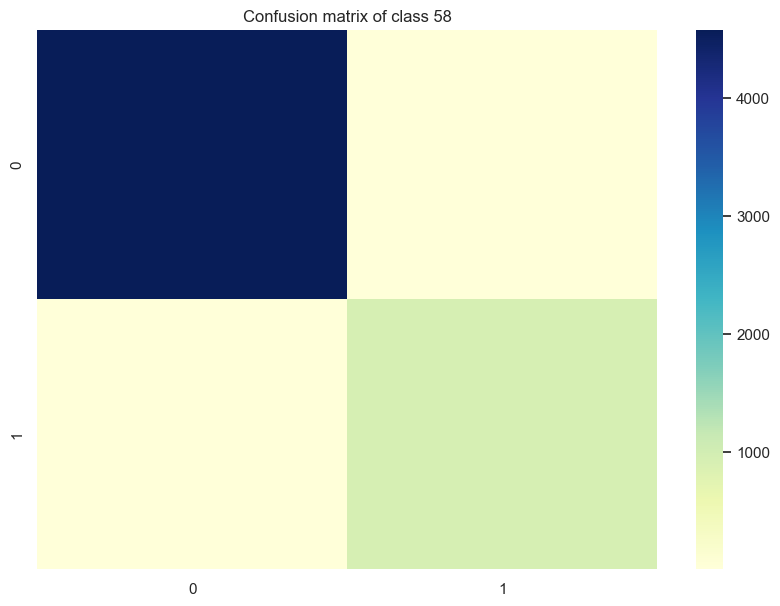

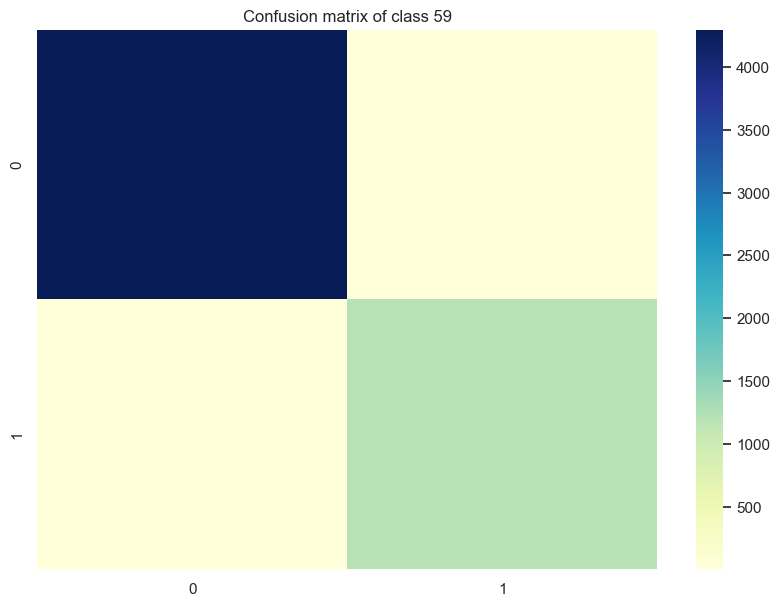

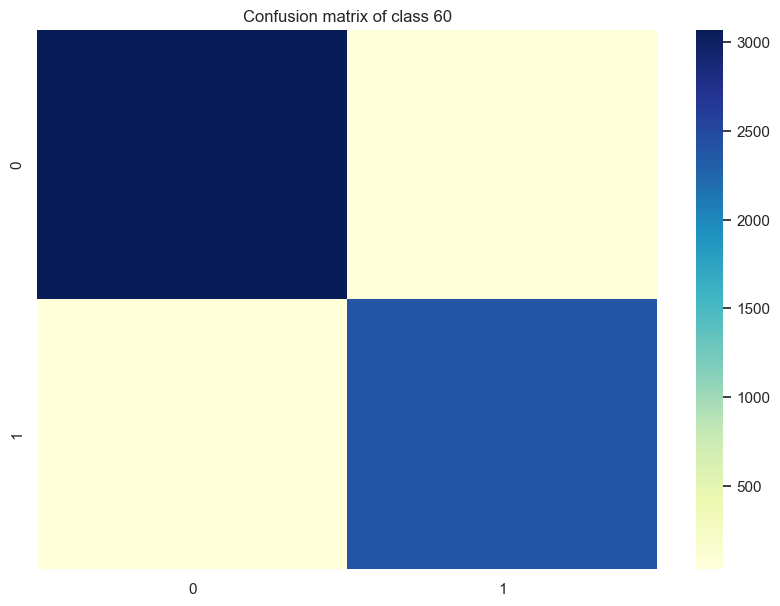

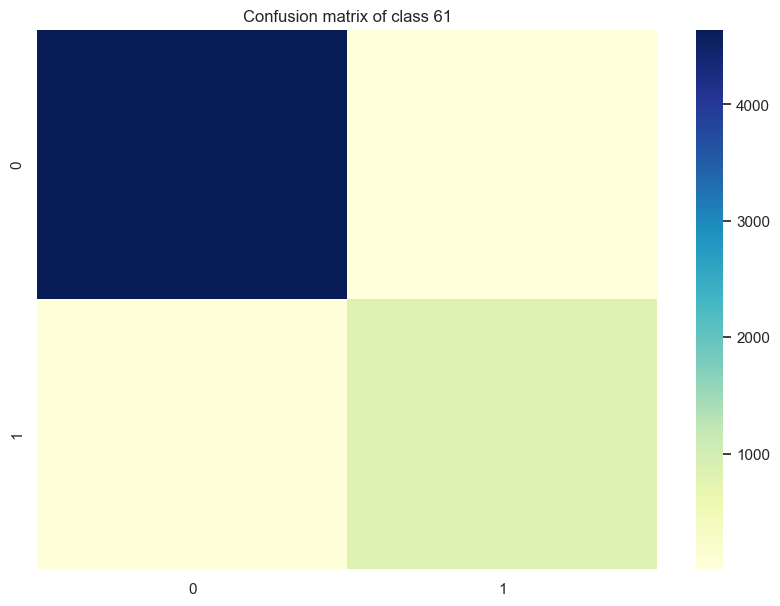

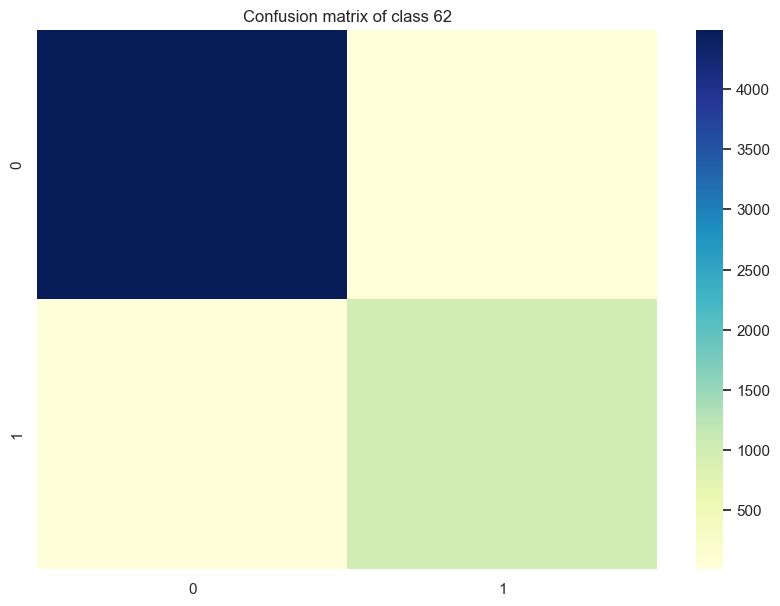

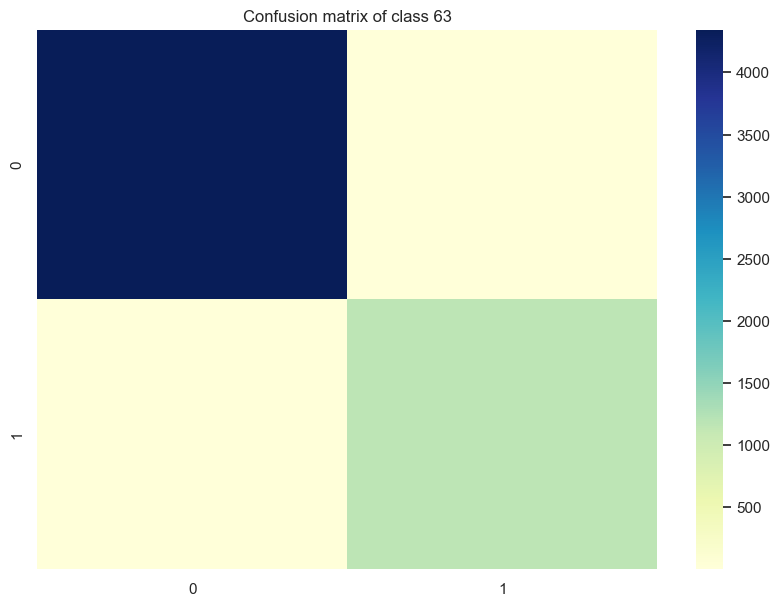

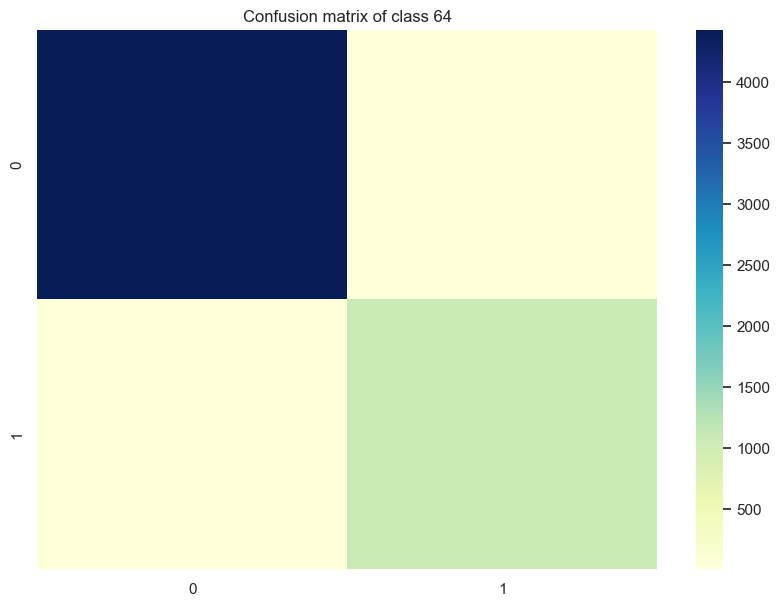

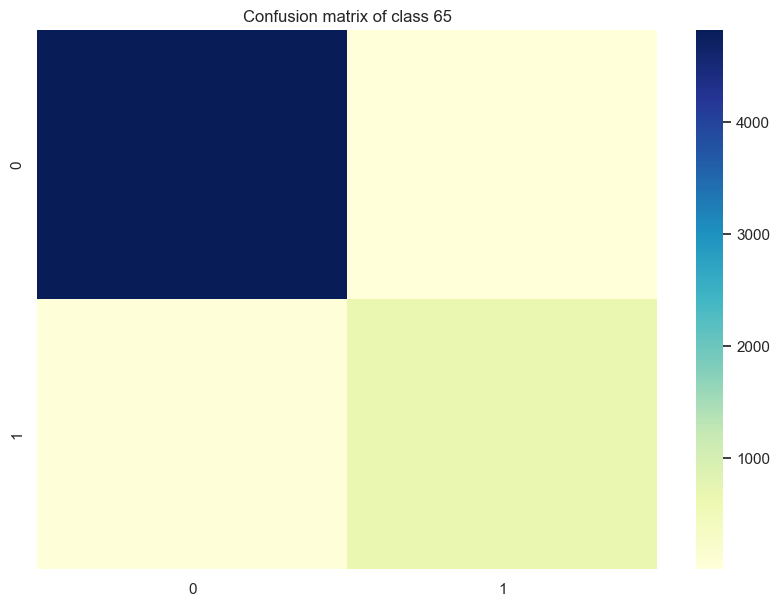

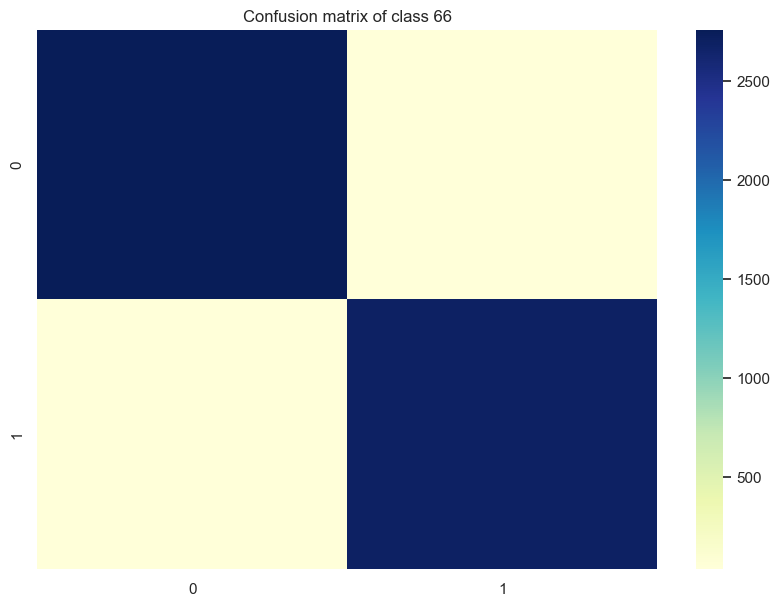

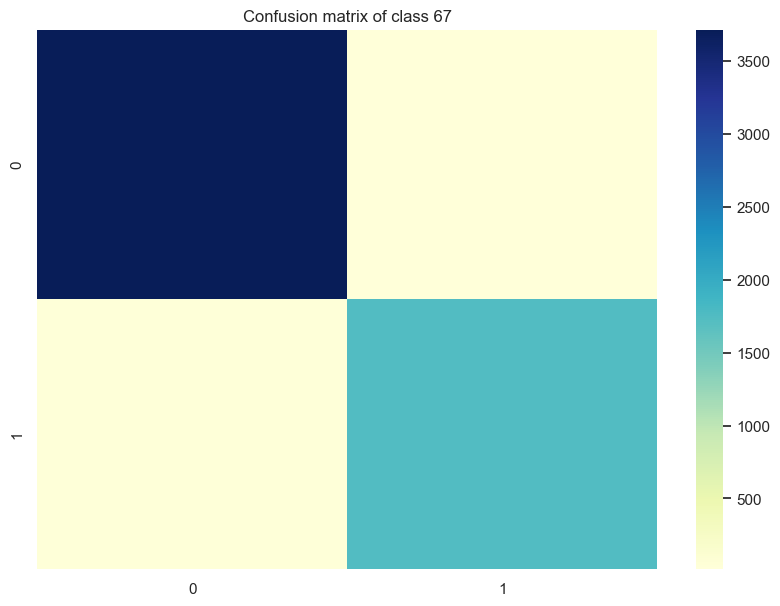

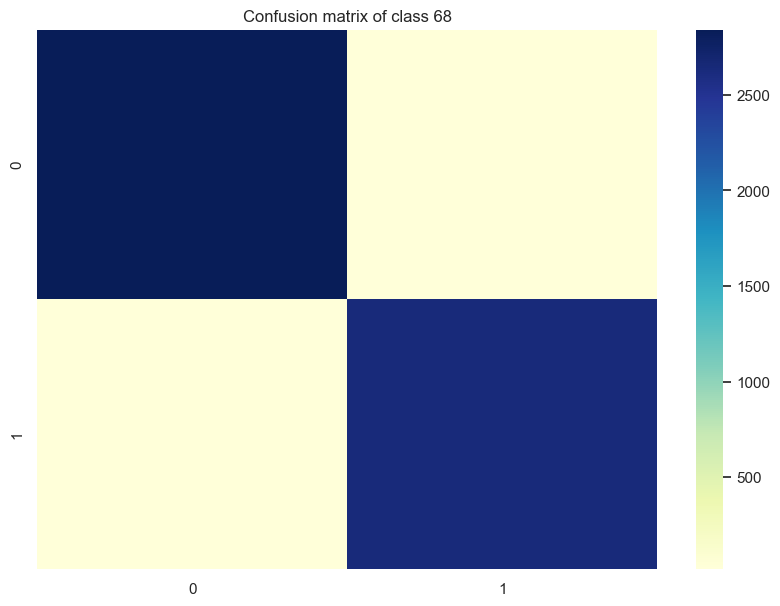

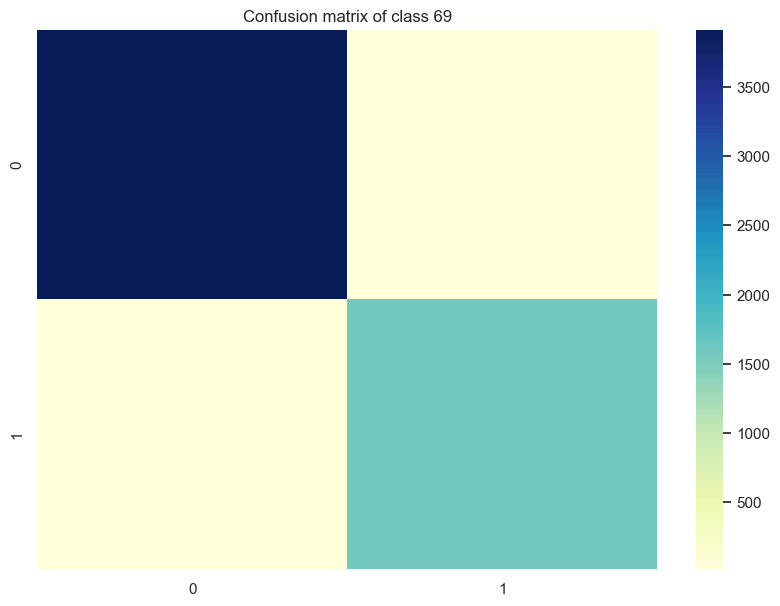

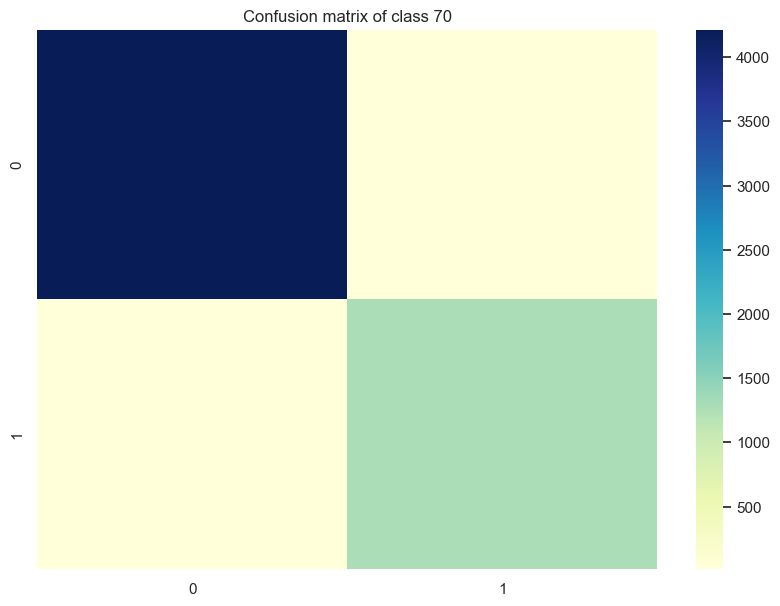

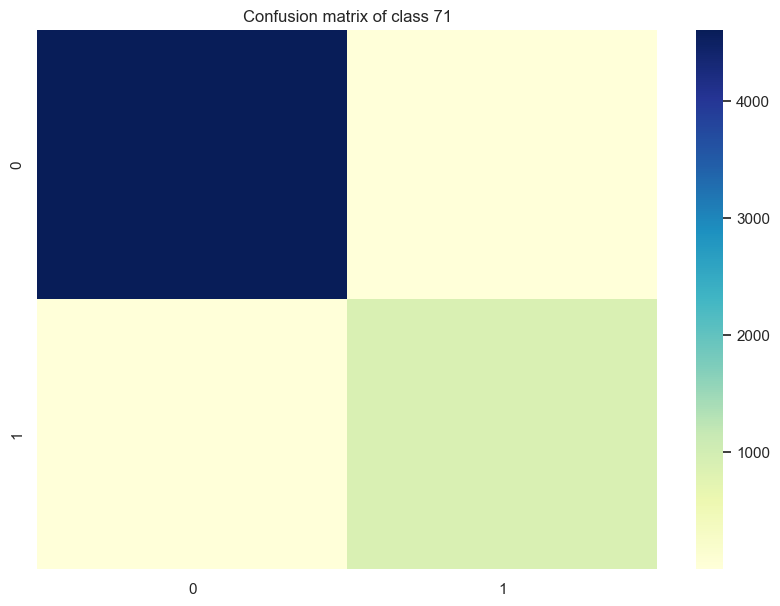

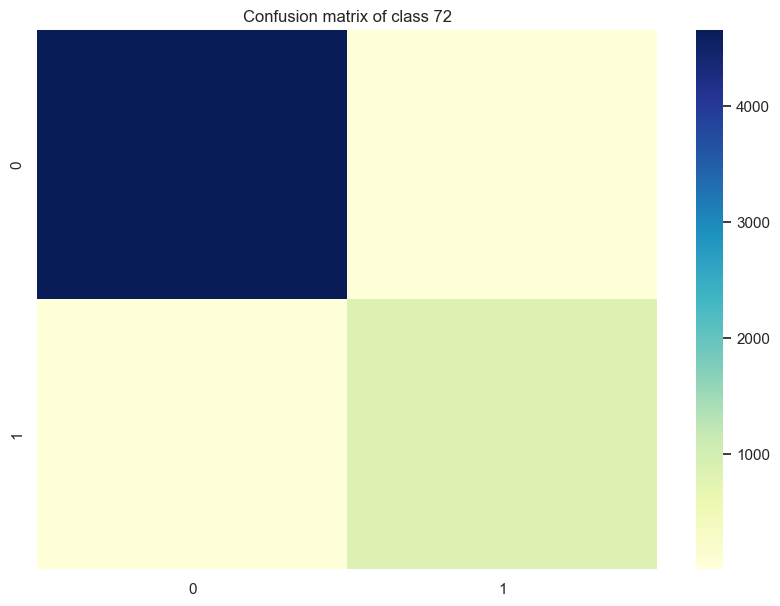

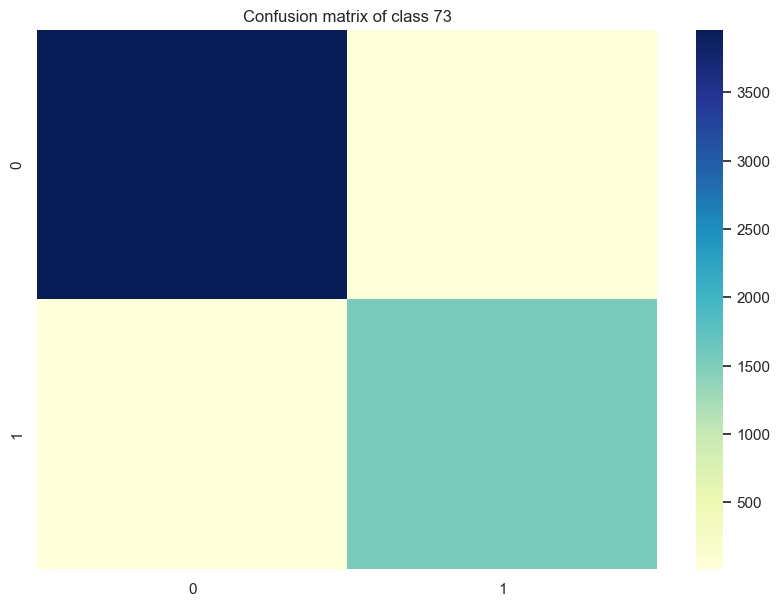

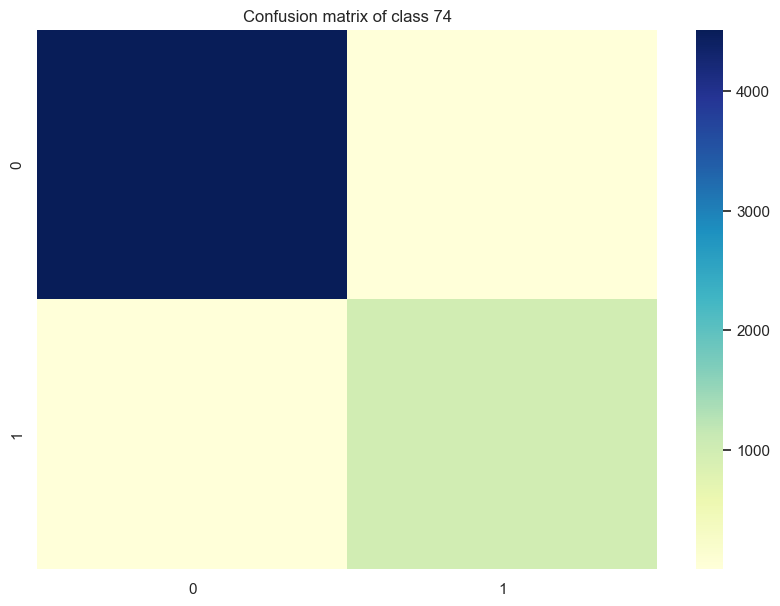

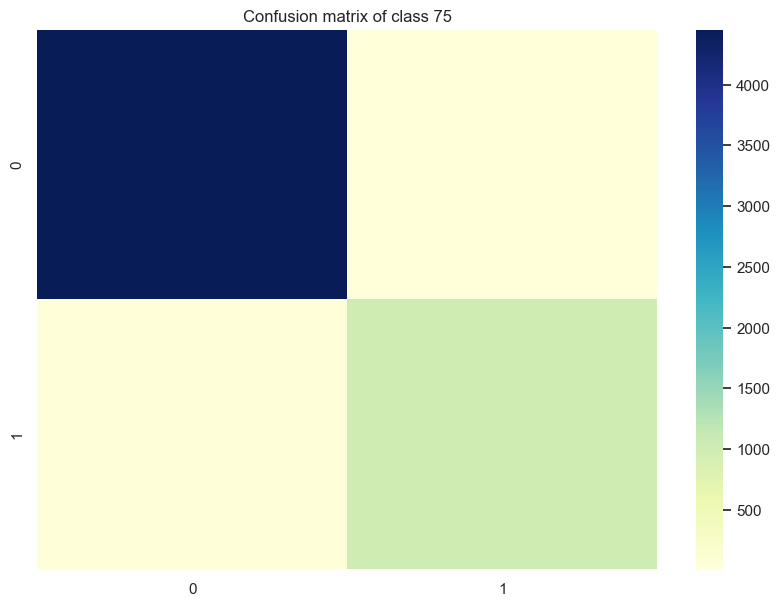

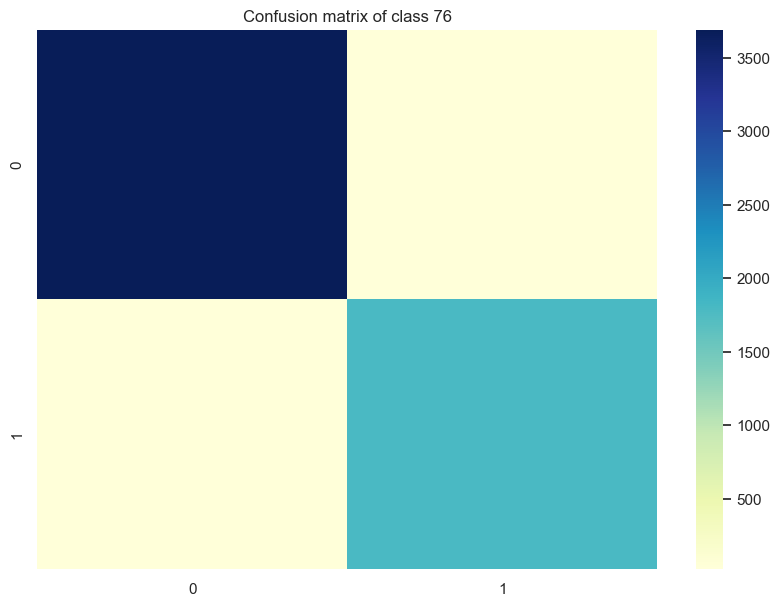

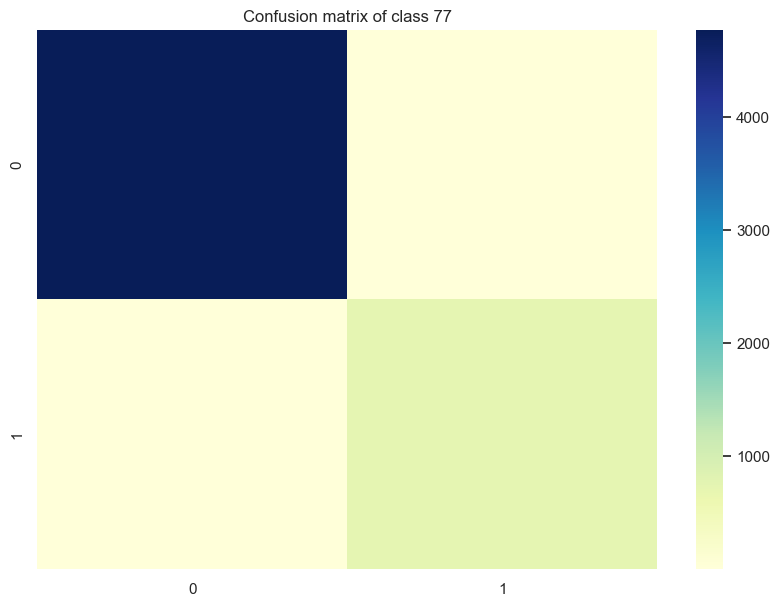

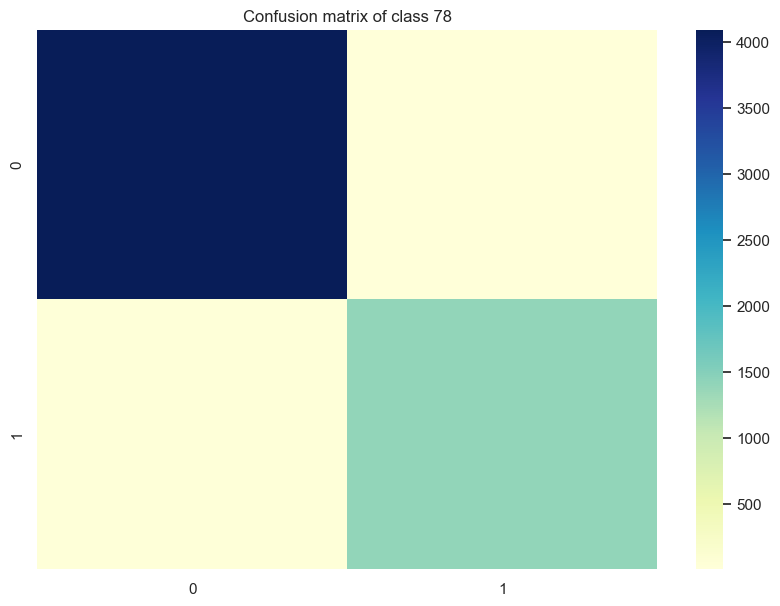

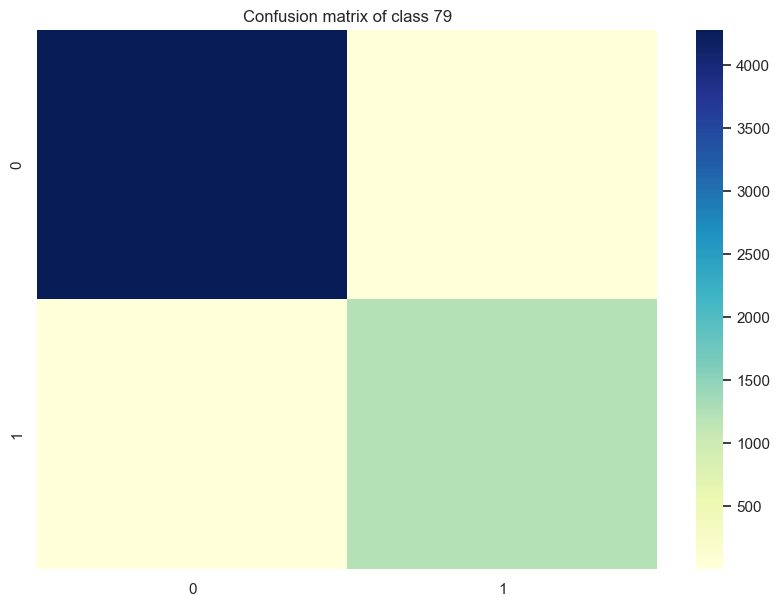

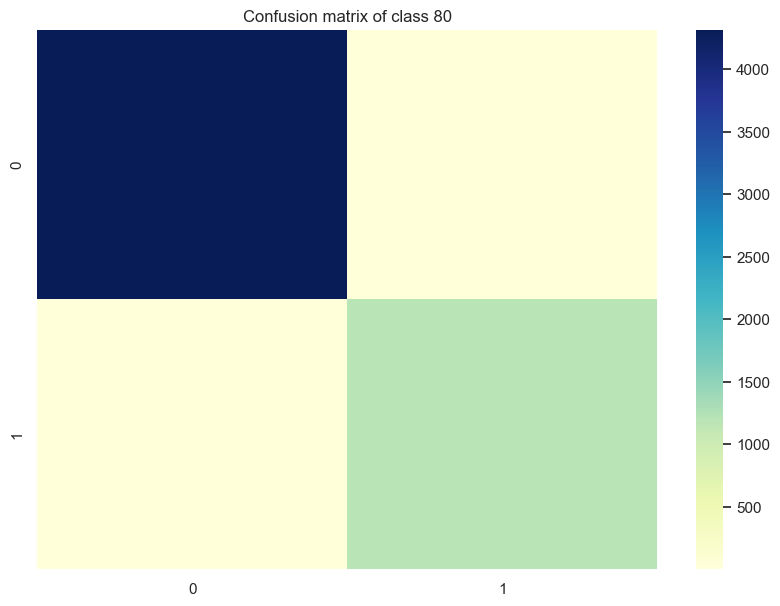

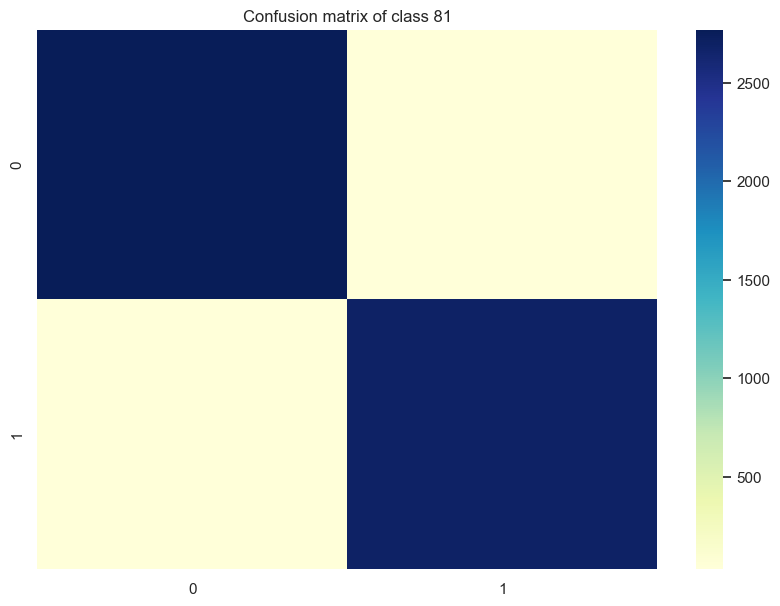

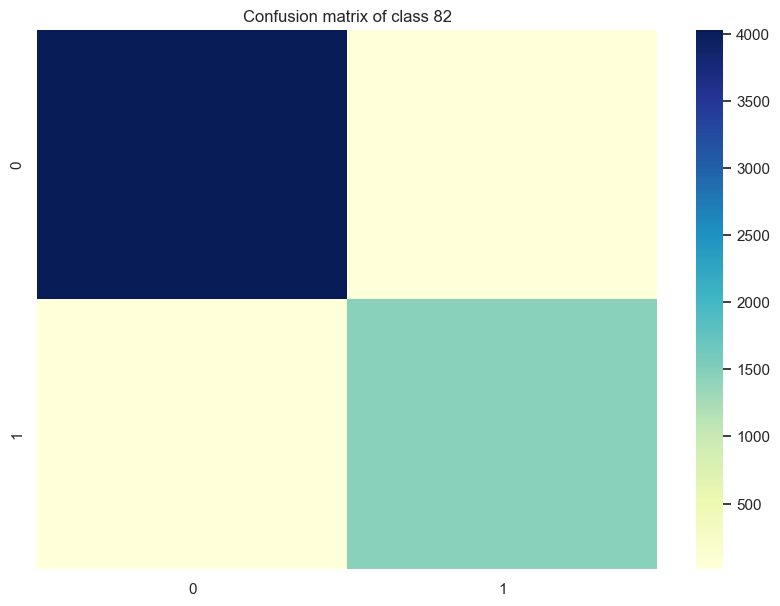

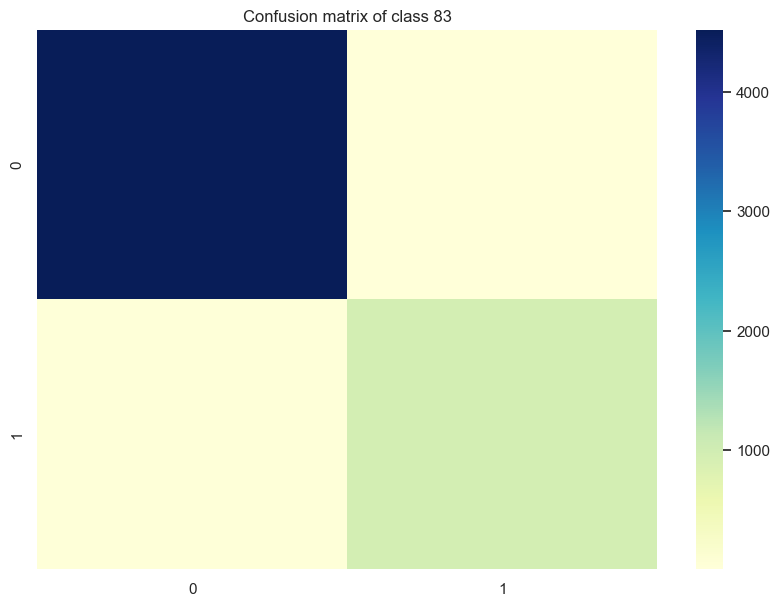

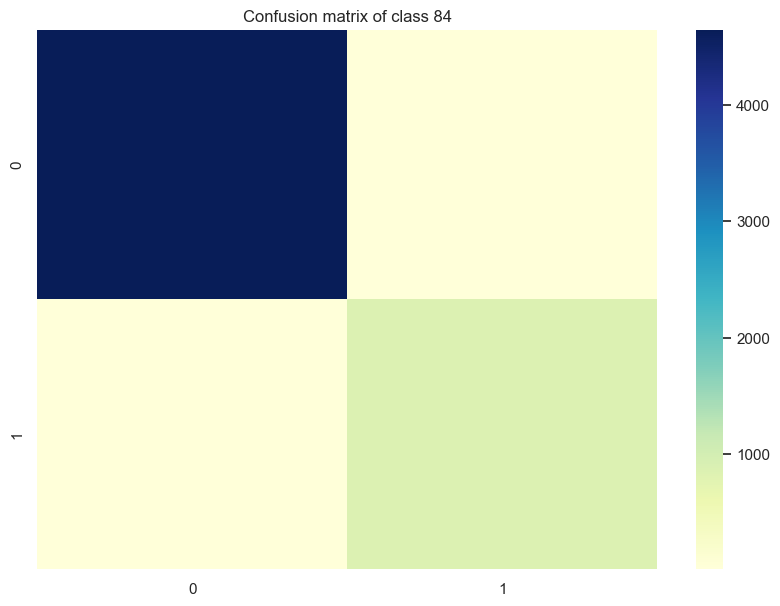

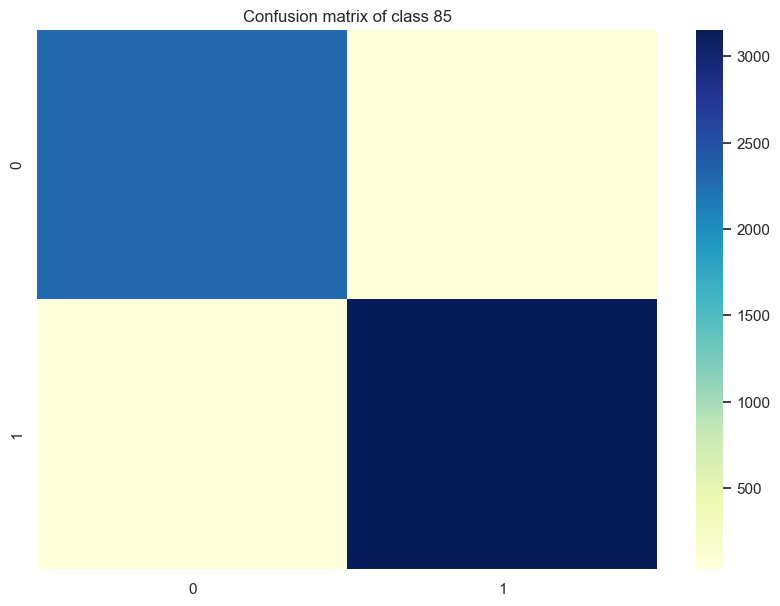

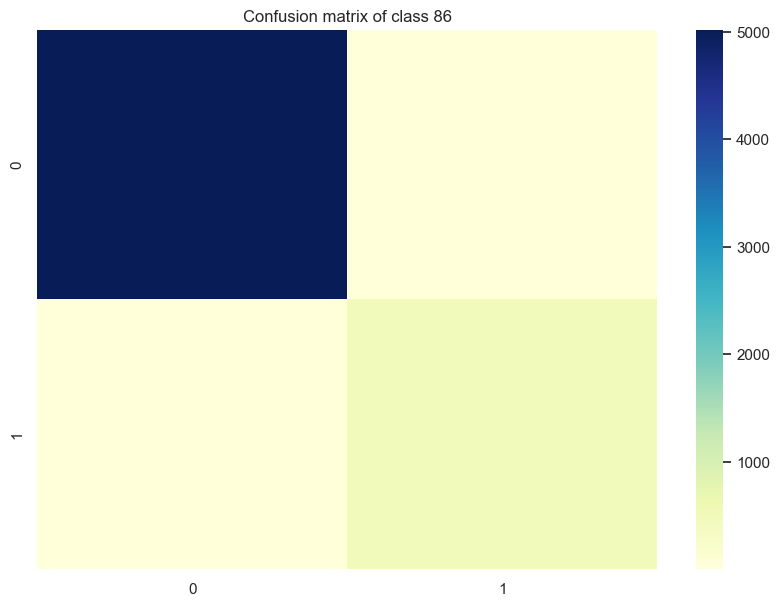

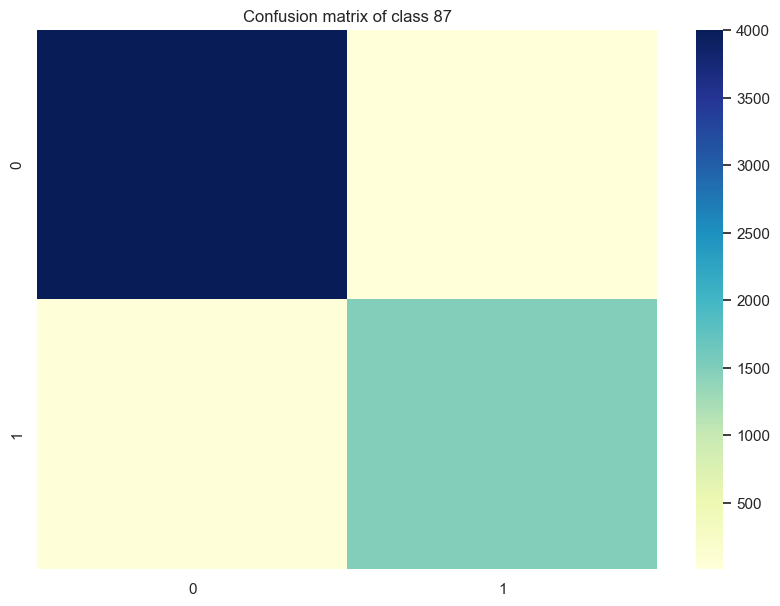

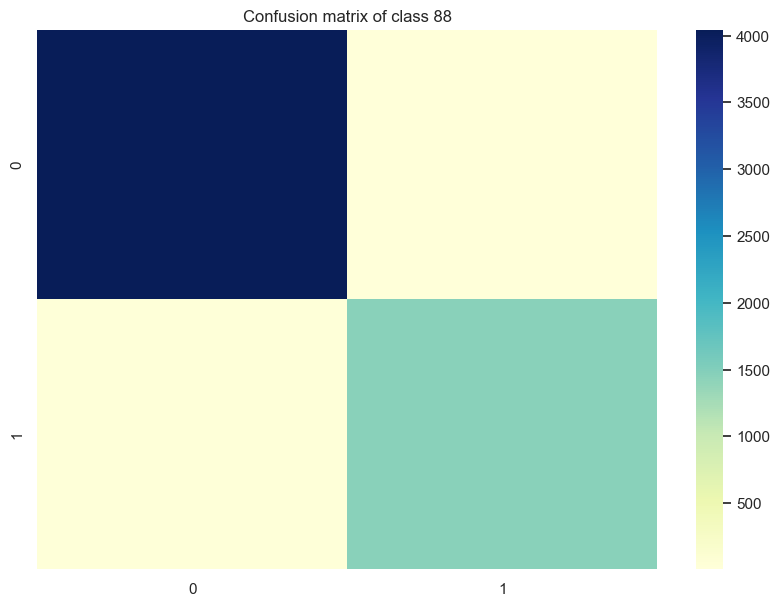

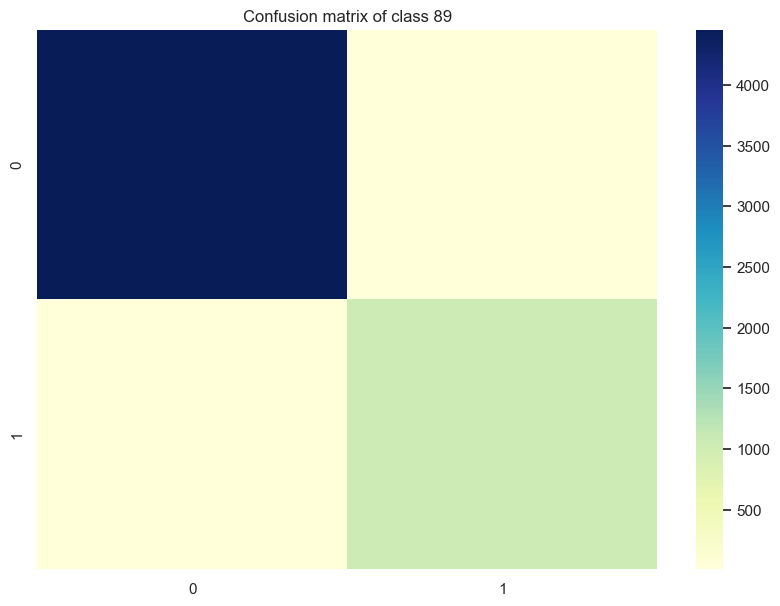

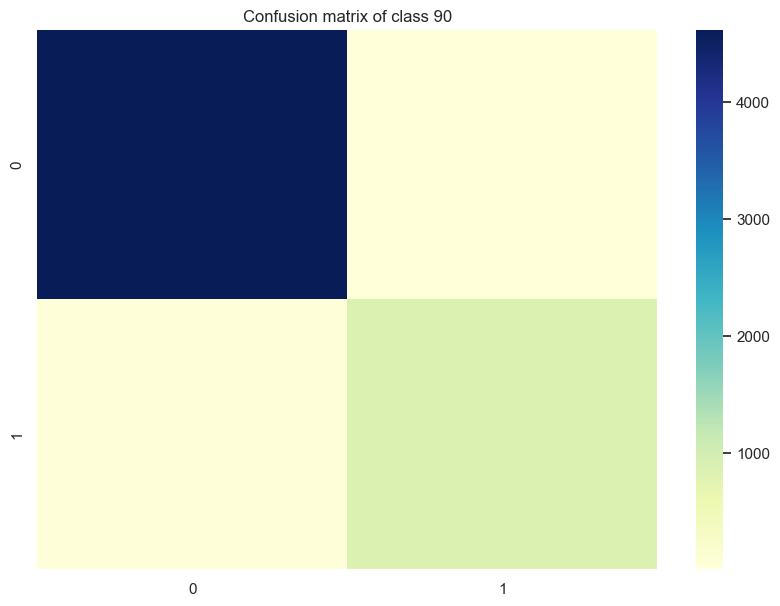

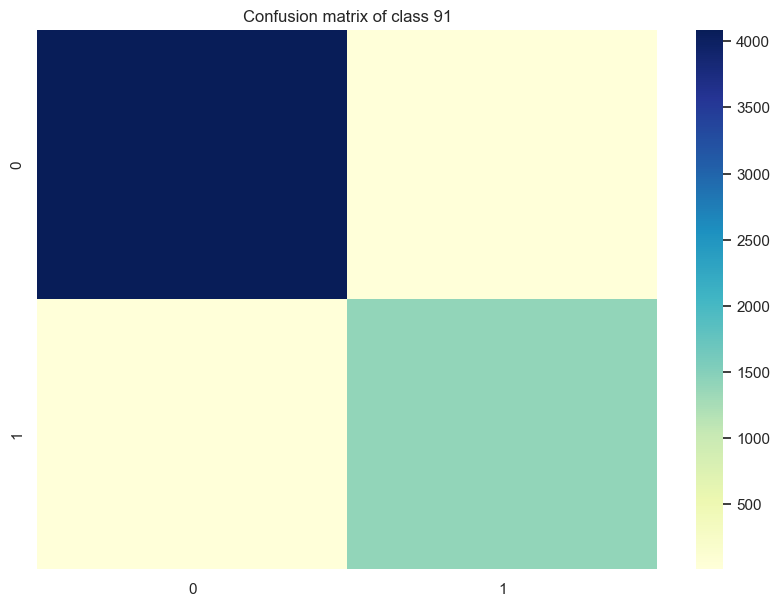

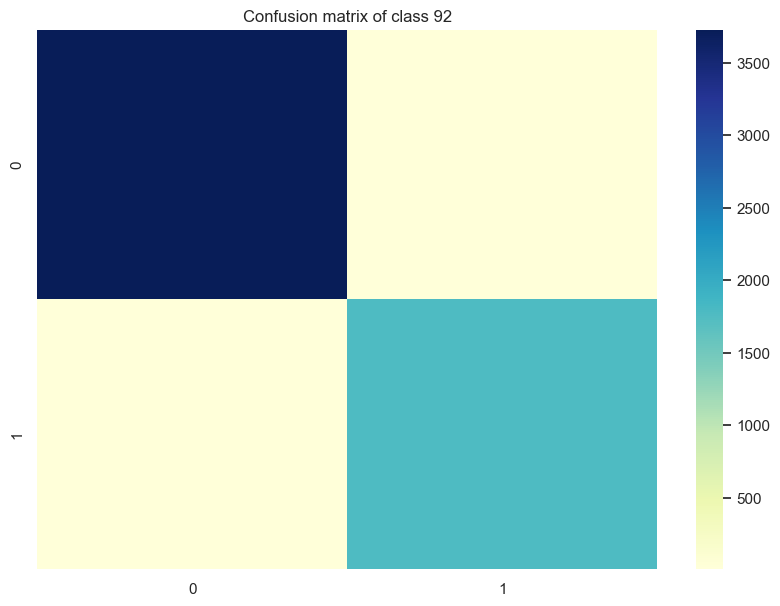

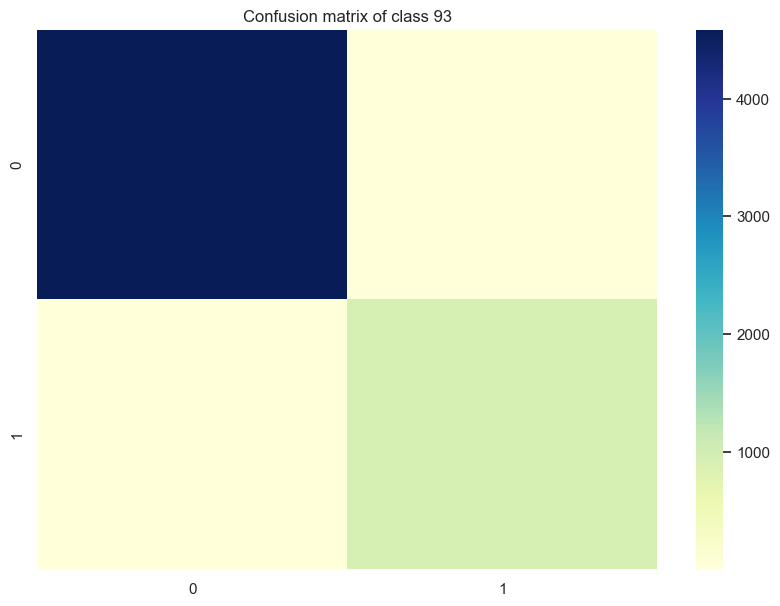

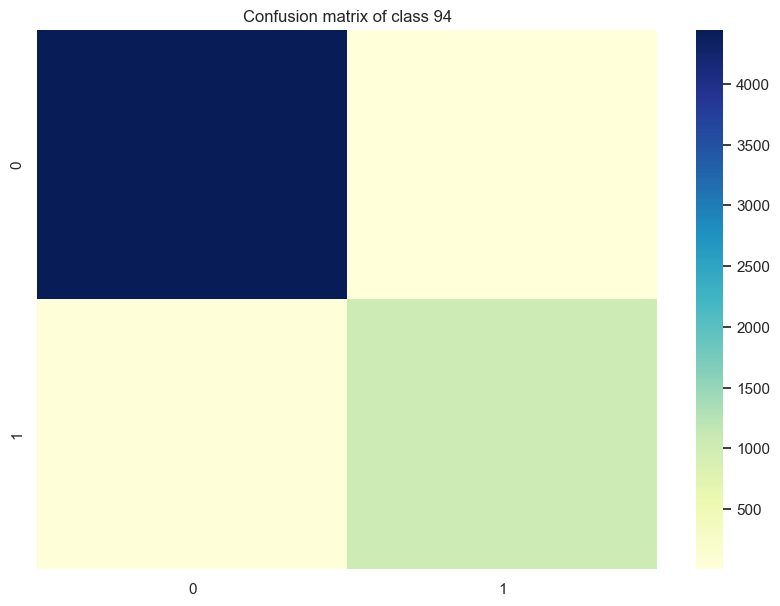

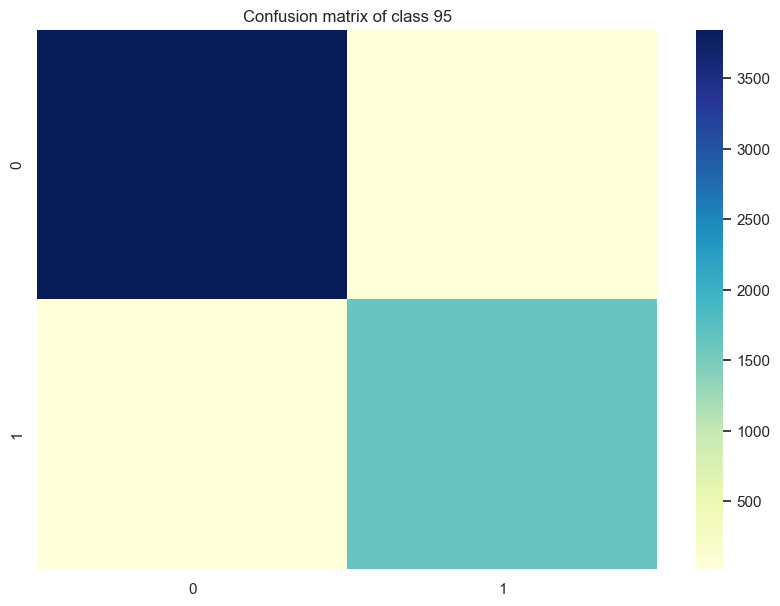

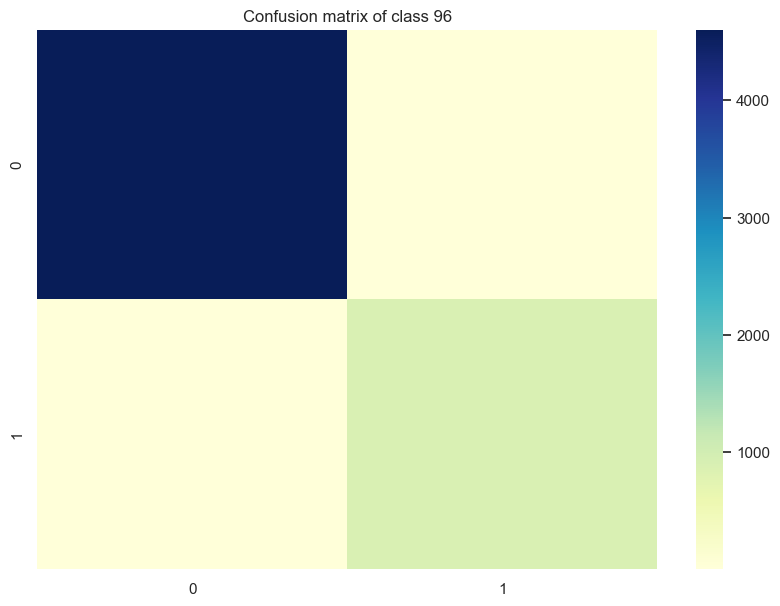

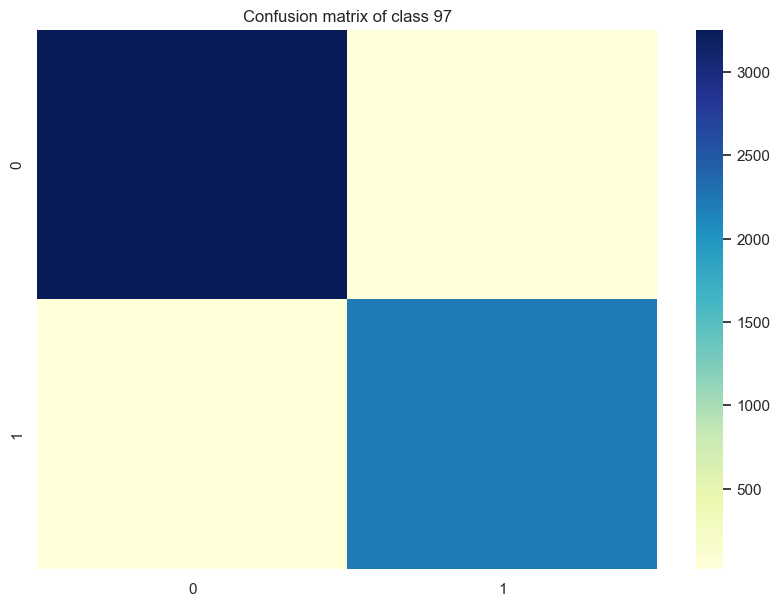

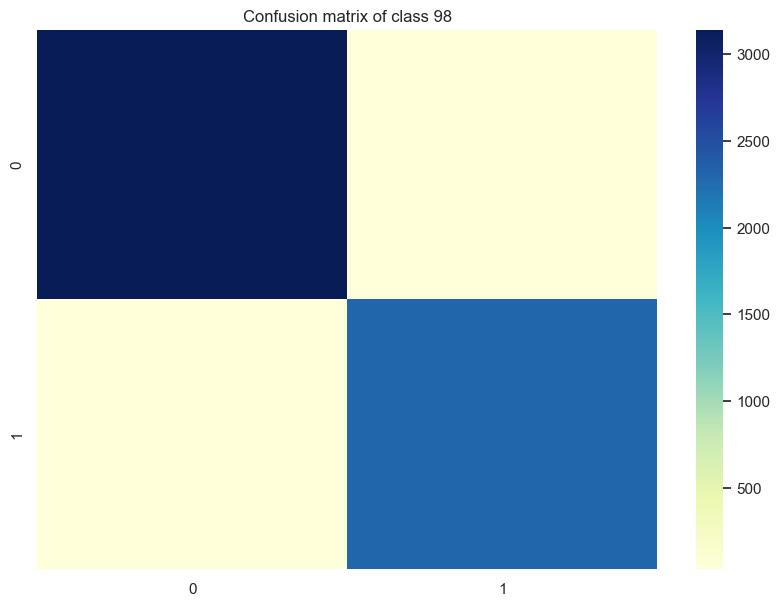

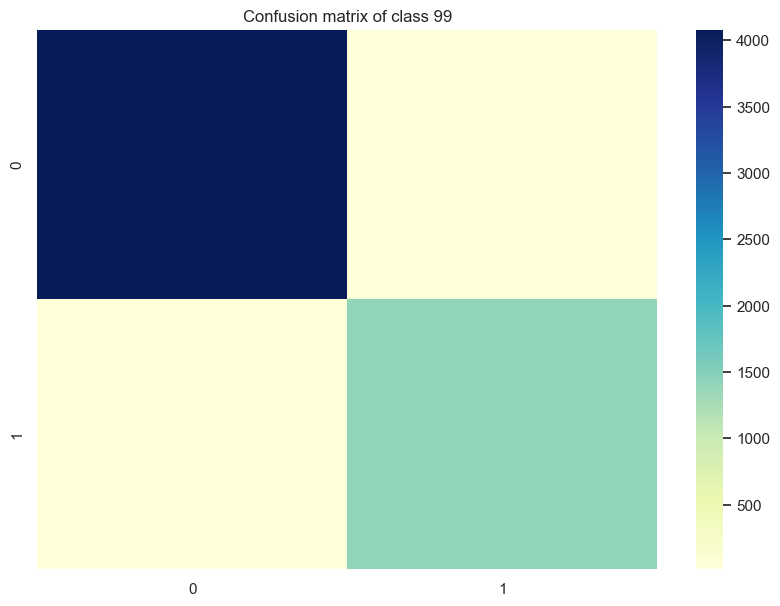

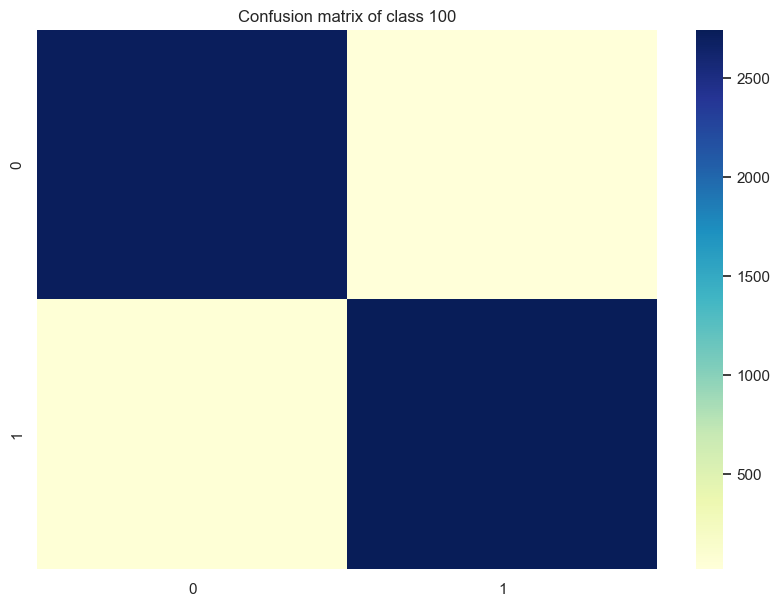

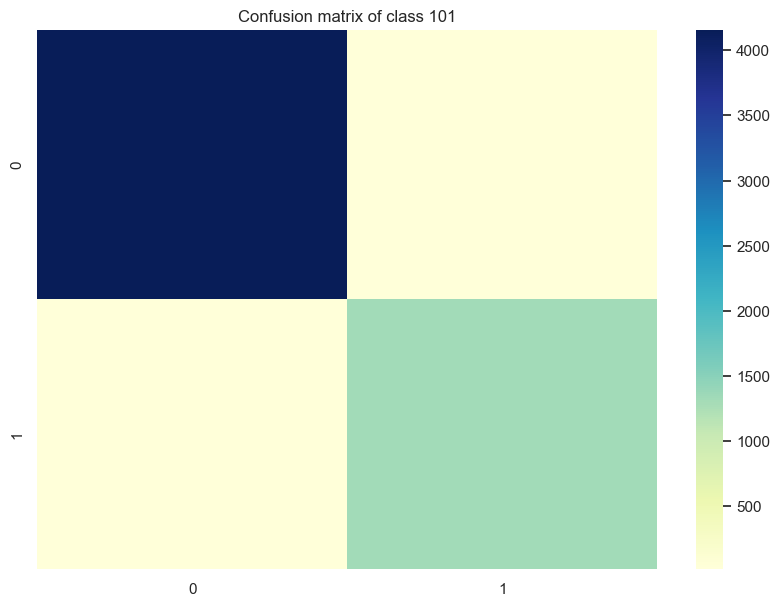

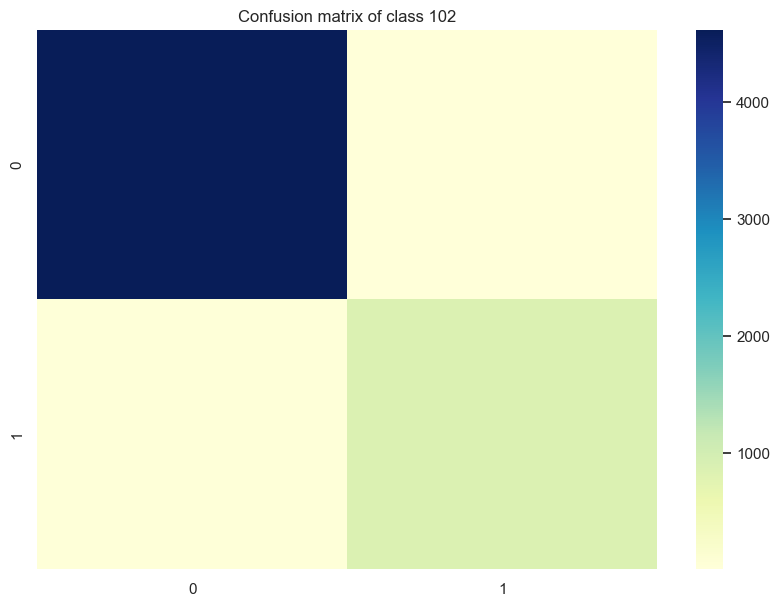

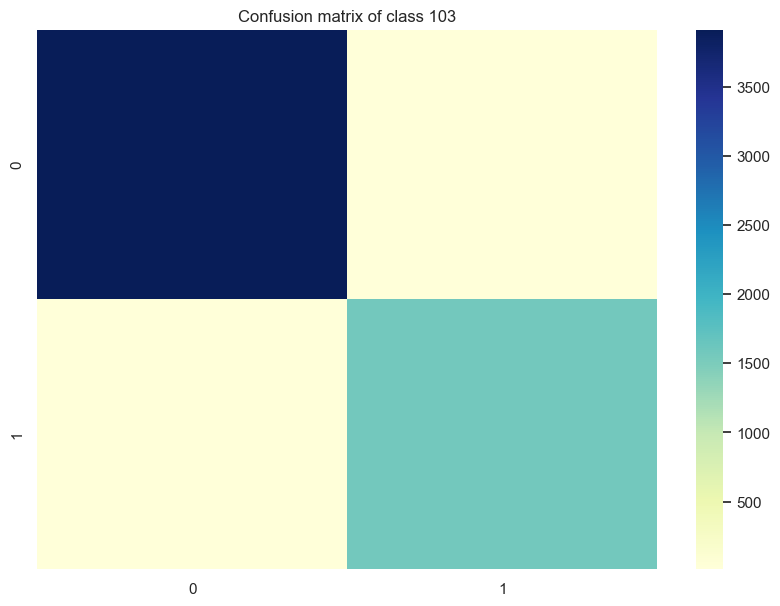

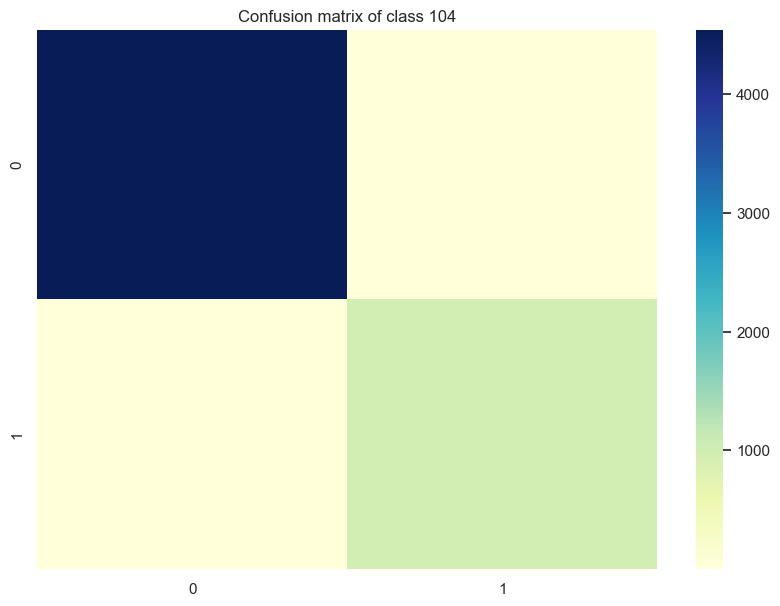

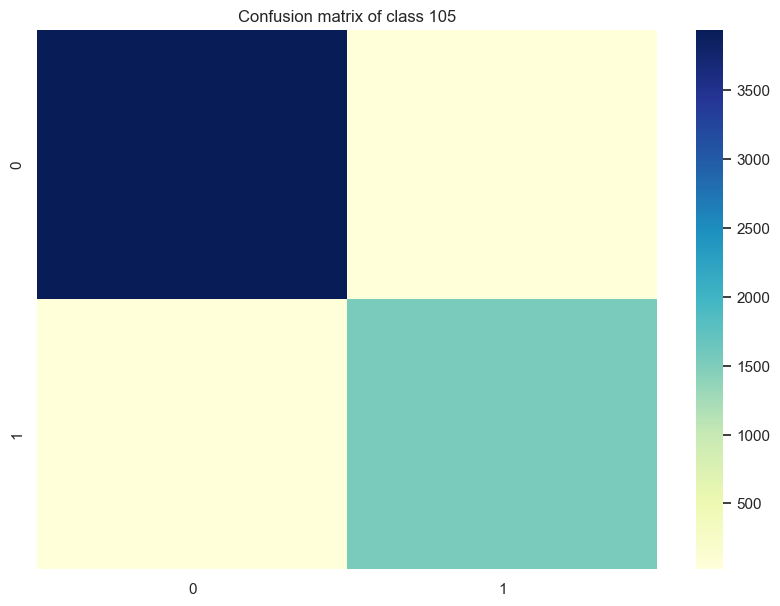

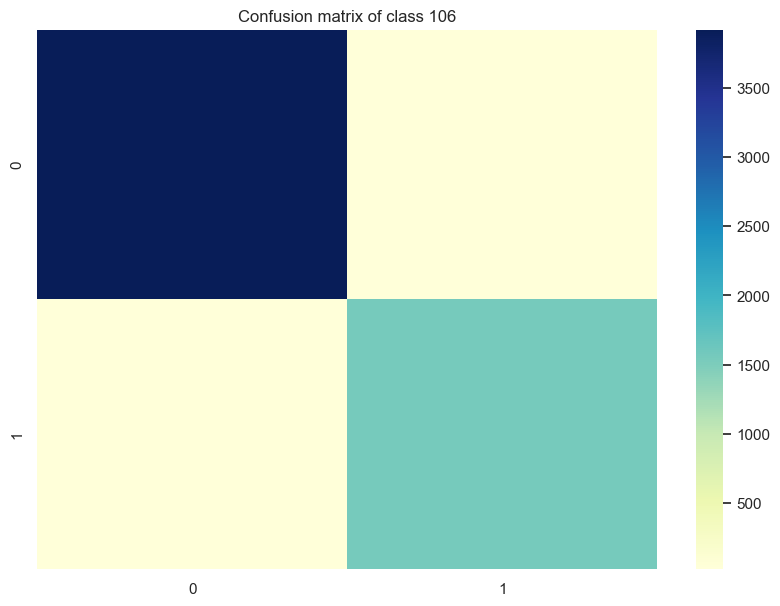

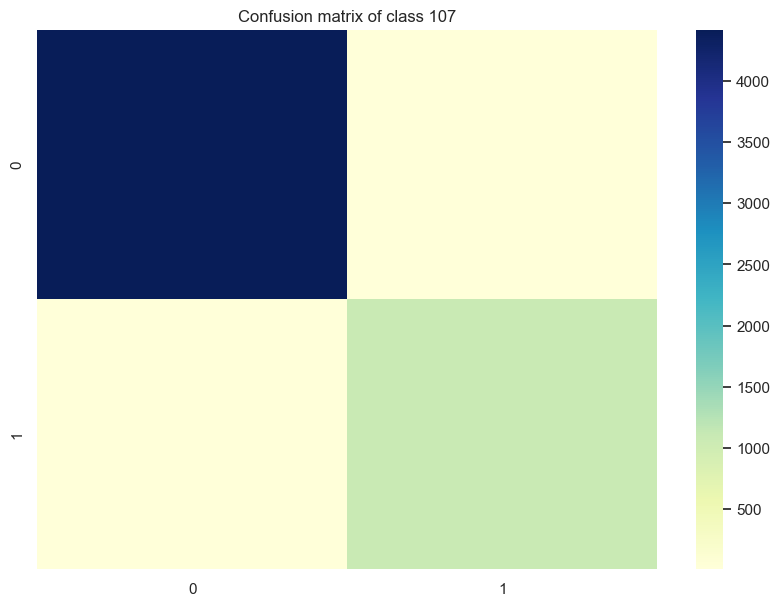

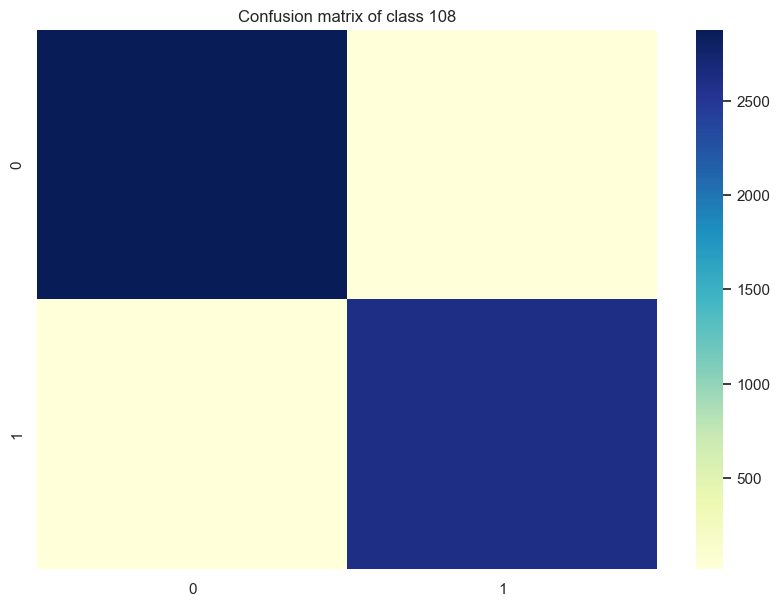

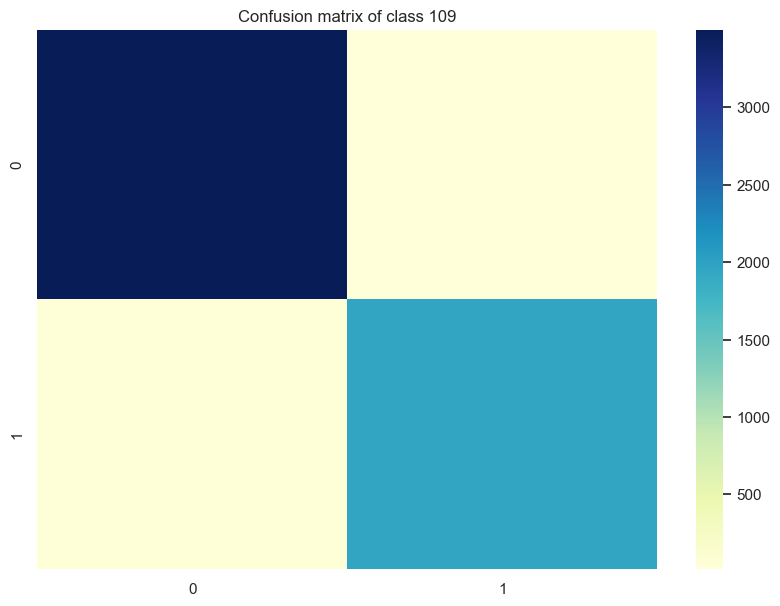

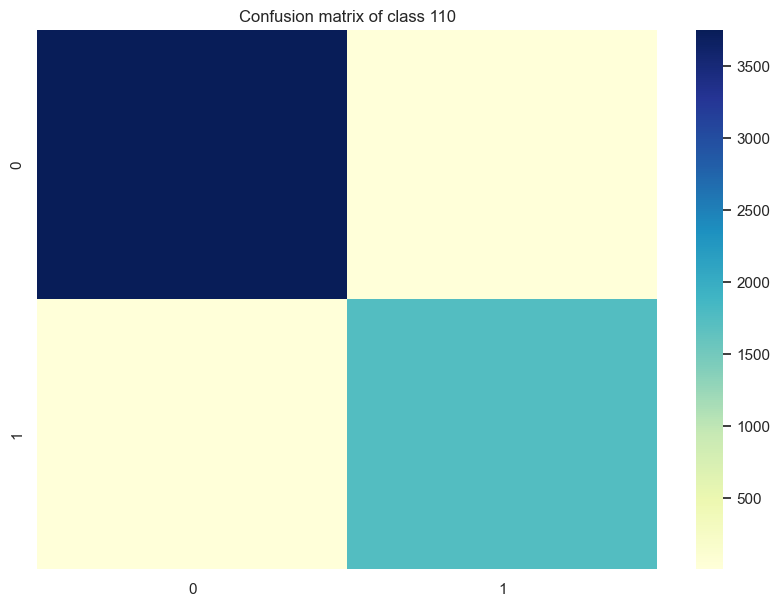

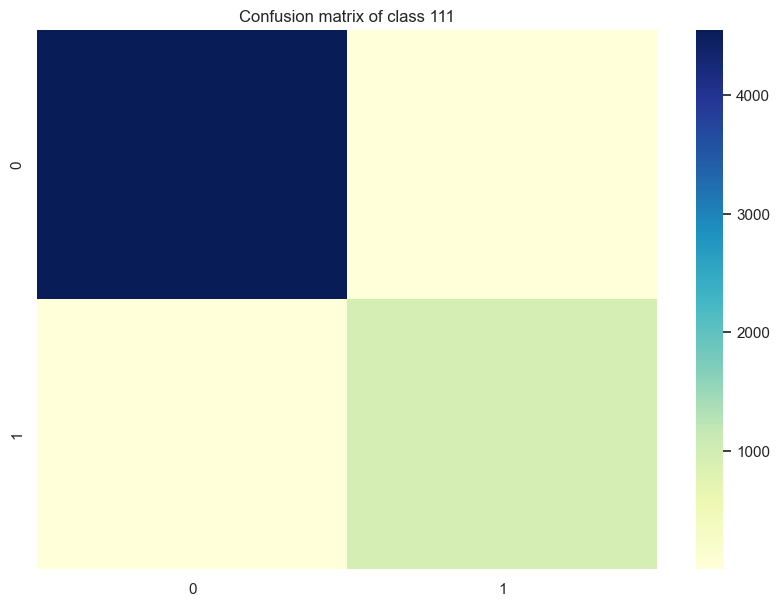

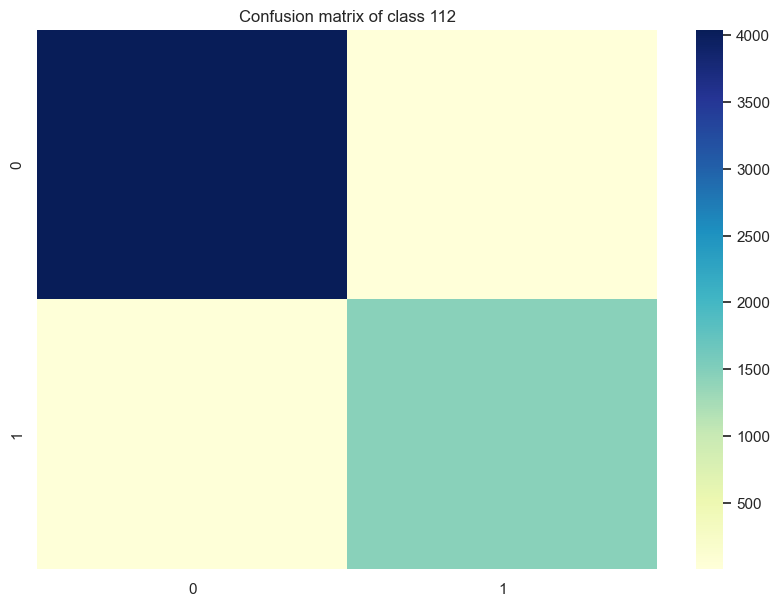

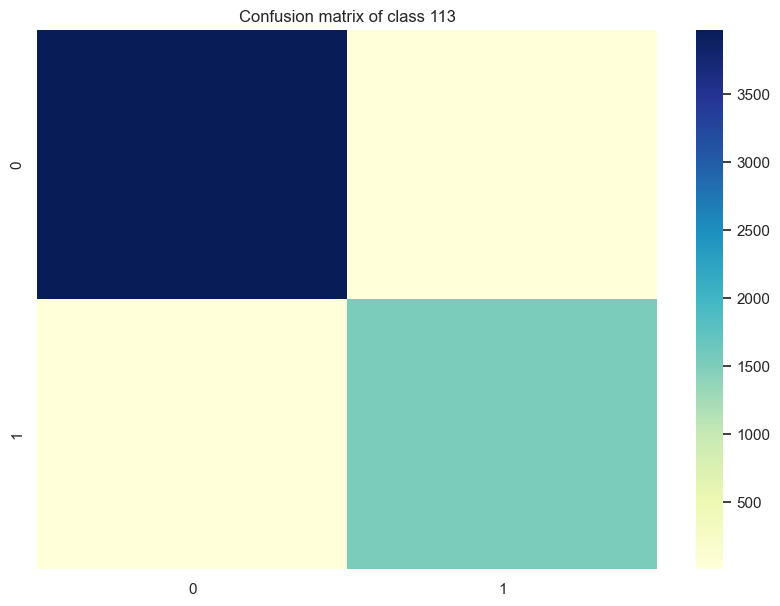

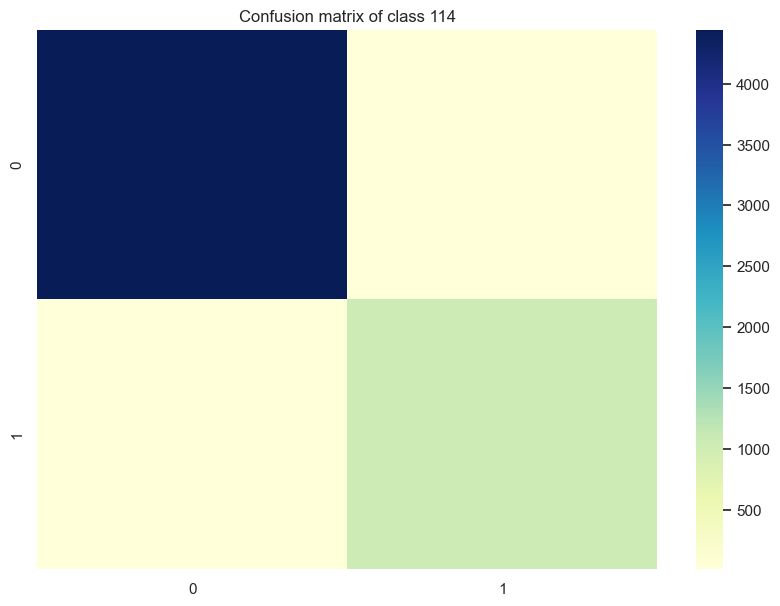

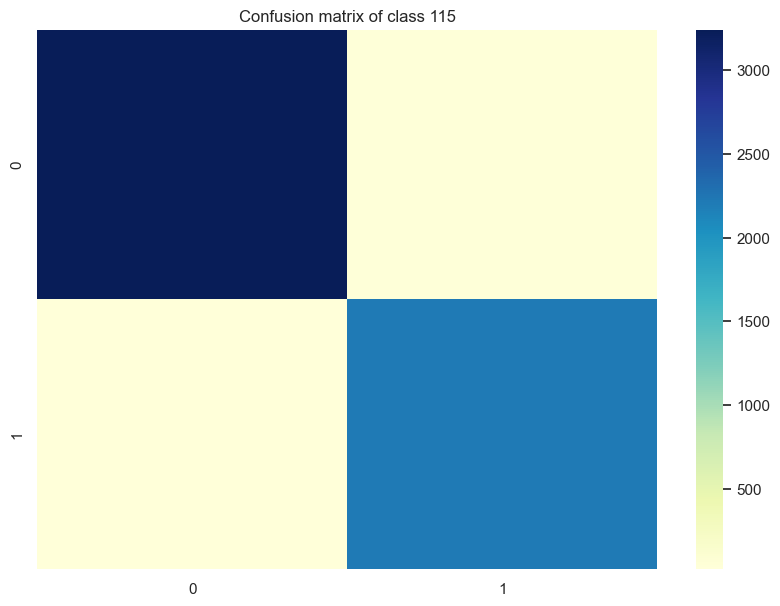

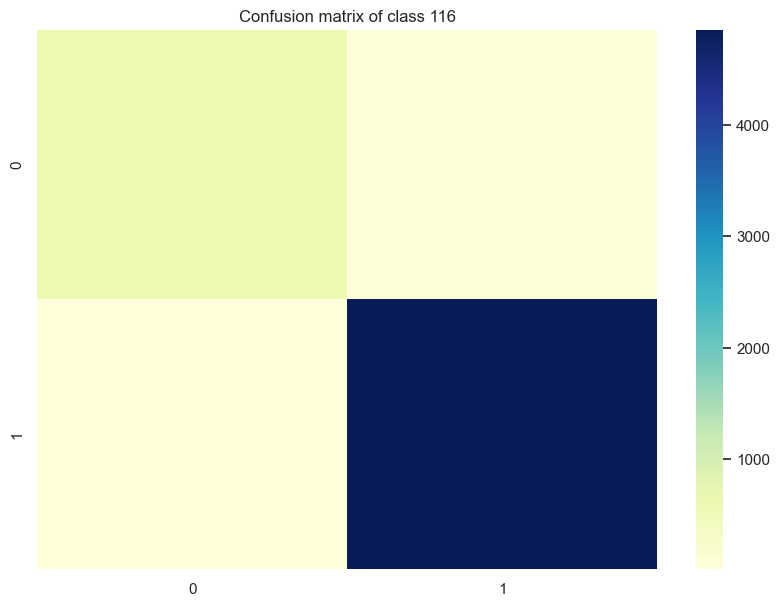

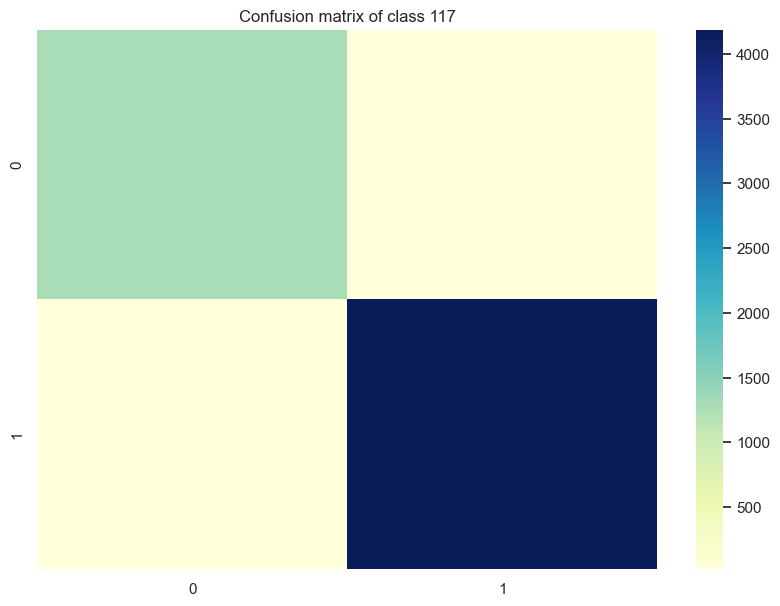

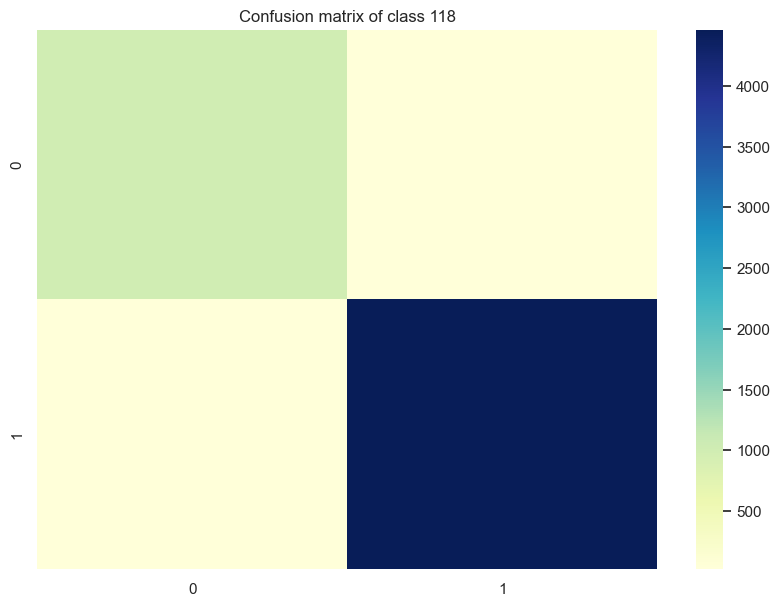

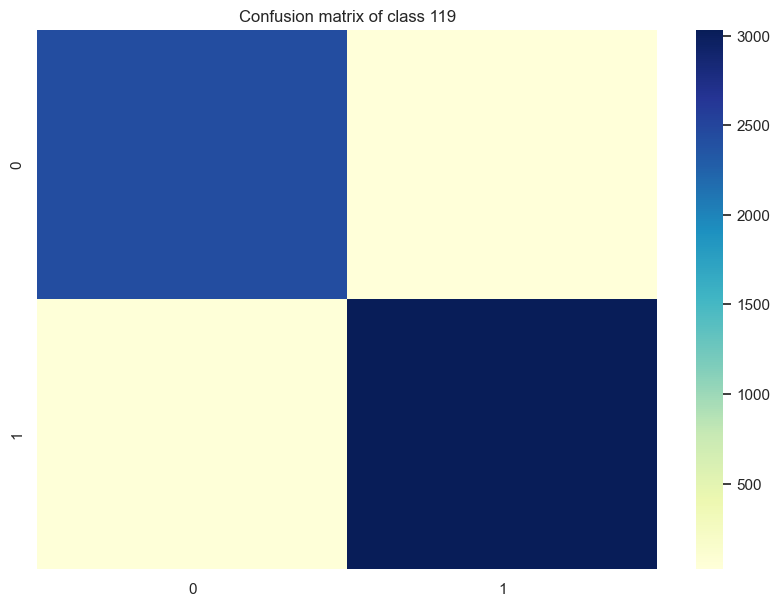

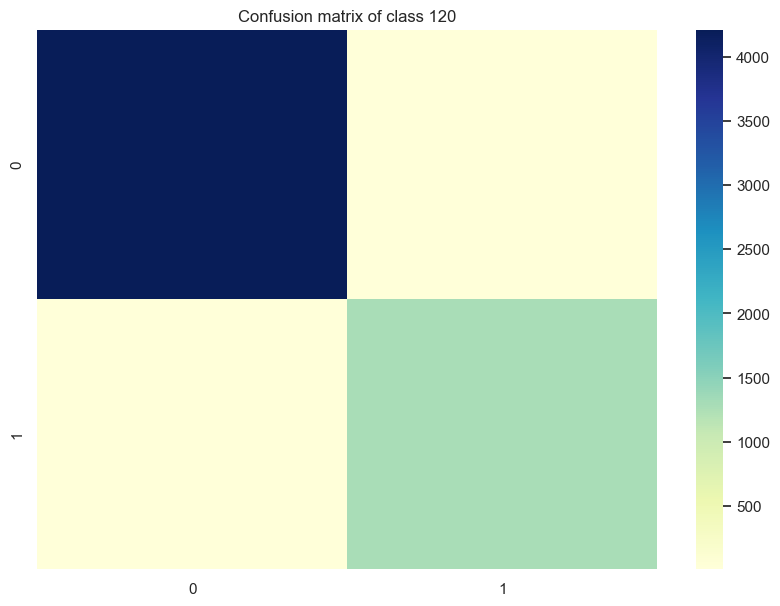

In [93]:
for class_i in range(len(matriz_confusion)):
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    sns.heatmap(matriz_confusion[class_i], cmap="YlGnBu", fmt='', ax=ax)
    plt.title(f'Confusion matrix of class {class_i}')